# RFM 분석 및 클러스터링 기반 고객 세분화를 통한 맞춤 상품 제안 및 세그먼트 활용 전략 수립

# 1.라이브러리 로드 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import datetime as dt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import Counter
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import cosine_similarity





# 2.데이터 개요 및 요약 

## 2-1.데이터 개요 

In [2]:
df=pd.read_csv('./ecommerce.csv', encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.shape

(541909, 8)

- InvoiceNo: 송장번호 , 문자 'C'로 시작하면 취소된 거래임을 의미 
- StockCode: 제품 코드 
- Description: 제품 이름
- Quantity: 거래당 각 제품의 수량 , ‘-’(마이너스)로 시작하면 취소된 거래임을 의미 
- InvoiceDate: 송장 날짜 및 시간
- UnitPrice: 제품 단가
- CustomerID: 고객 고유 번호 
- Country: 국가 이름

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 2-2.데이터 통계요약

In [6]:
# 문자열 데이터 요약 통계 
# InvoiceNo와 StockCode는 문자열+숫자 혼합되어 있다.
df.select_dtypes(include='object').describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [7]:
# 수치형 데이터 요약 통계
# Quantity가 음수인 값은 InvoiceNo이 취소된 주문건
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# 3. 데이터 전처리

## 3-1.결측치

In [8]:
# 결측치 확인, Description과 CustomerID에 결측치 있음 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# 결측치 비율 확인 
# Description은 0.27%로 미미한 수준, CustomerID는 25%
df.isnull().sum()/df.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

- CustomerID 의 결측치는 약 25%로, 결측값은 분석에 편향이 발생할 수 있으므로, 해당 결측치는 삭제하는것으로 결정 

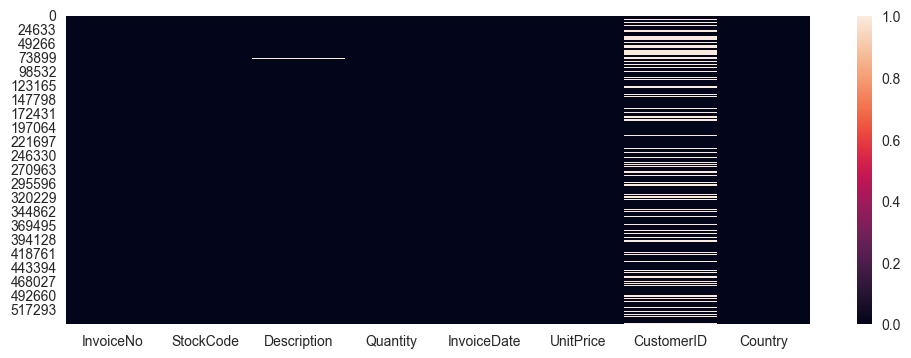

In [10]:
# 결측치 시각화 
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull())
plt.show()

In [11]:
# 결측치 처리 (삭제처리)
df1=df.copy()
df1 = df1.dropna(subset=['CustomerID', 'Description'])
df1.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 3-2.중복값 처리 

In [12]:
# 중복데이터 확인 , keep='False'설정으로, 중복데이터 모두 확인 
df1[df1.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [13]:
print('중복 데이터 처리 전 :',df1.shape)
df1=df1.drop_duplicates()
print('중복 데이터 처리 후 :',df1.shape)

중복 데이터 처리 전 : (406829, 8)
중복 데이터 처리 후 : (401604, 8)


## 3-3.데이터 정리

### InvoiceNo
- InvoiceNo의 첫글자가 'C'로 시작하는 것은 취소된 거래임을 뜻함 
- transaction_status 컬럼을 추가하여 취소 여부 데이터 기입 

In [14]:
# InvoiceNo컬럼에서 알파벳을 포함하는 데이터 추출 
df1.loc[df1['InvoiceNo'].str.contains('[a-zA-Z]')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [15]:
# transaction_status 컬럼을 추가하여 취소 여부 데이터 기입 
df1.loc[:, 'transaction_status'] = 'Finished'
df1.loc[df['InvoiceNo'].str.contains('[a-zA-Z]'),'transaction_status']='Cancelled'
df1['transaction_status'].value_counts()

transaction_status
Finished     392732
Cancelled      8872
Name: count, dtype: int64

In [16]:
# 총 거래에서 취소된 거래의 비율 확인 => 1.63%로 미비하다. 
df1[df1['transaction_status']=='Cancelled'].shape[0]/df.shape[0]*100

1.6371752452902608

### StockCode
-  StockCode에서 숫자가 0이나 1개만있는것은 상품이아닌 서비스임을 나타내고 있고, 해당 컬럼 비율은 0.47% 로 미미하므로, 필터링 

In [17]:
# StockCode에서 알파벳을 포함하는 데이터 추출 
df1[df1['StockCode'].str.contains('[a-zA-z]')]['StockCode'].head()

0     85123A
2     84406B
3     84029G
4     84029E
45      POST
Name: StockCode, dtype: object

In [18]:
# StockCode unique코드에서 숫자로 이루어져있는 글자의 갯수 확인 
unique_stock_code=df1['StockCode'].unique()
pd.Series(unique_stock_code).apply(lambda x:sum(i.isdigit()  for i in str(x))).value_counts()

5    3676
0       7
1       1
Name: count, dtype: int64

In [19]:
# 숫자가 0이나 1만 있는 문자열 확인 
abnormal_stockcode=[i for i in unique_stock_code if sum(c.isdigit()for c in str(i)) in (0,1)]
abnormal_stockcode

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

In [20]:
# 숫자가 0이나 1만 있는 문자열의 비율 확인 
df1['StockCode'].isin(abnormal_stockcode).sum()/df1.shape[0]*100

0.4768378801007958

In [21]:
# 숫자가 0이나 1만 있는 문자열 확인 시, 제품이 아닌 서비스 관련 내용이므로 필터링 필요함 
df1[df1['StockCode'].isin(abnormal_stockcode)]['Description'].unique()

array(['POSTAGE', 'Discount', 'CARRIAGE', 'Manual', 'Bank Charges',
       'PADS TO MATCH ALL CUSHIONS', 'DOTCOM POSTAGE', 'CRUK Commission'],
      dtype=object)

In [22]:
# 필터링 
df1=df1[~df1['StockCode'].isin(abnormal_stockcode)]

### Description


In [23]:
# Description 확인 시, 상품 기입코드가 모두 대문자로 확인됨 
df1['Description'].value_counts()[:10]

Description
WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
LUNCH BAG RED RETROSPOT               1345
SET OF 3 CAKE TINS PANTRY DESIGN      1224
LUNCH BAG  BLACK SKULL.               1099
PACK OF 72 RETROSPOT CAKE CASES       1062
SPOTTY BUNTING                        1026
Name: count, dtype: int64

In [24]:
# 소문자로 되어 있는 데이터가 있는지 확인해보기 
lowercase_description=df1['Description'].unique()
lowercase_description=[d for d in lowercase_description if any(c.islower() for c  in d)]
lowercase_description

['BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No ',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'High Resolution Image']

- 소문자를 포함하는 상품 설명은 상품설명이 아닌 서비스 세부정보인Next Day Carriage와 High Resolution Image 확인됨 

In [25]:
# 서비스관련 내용 필터링, 나머지 데이터는 대문자로 바꿔주기 
service_col=['Next Day Carriage','High Resolution Image']
df1=df1[~df1['Description'].isin(service_col)]
df1['Description']=df['Description'].str.upper()

## UnitPrice
- UnitPrice는 최소값이 0으로 0보다 큰 데이터만 필터링 

In [26]:
df1['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [27]:
df1[df1['UnitPrice']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,transaction_status
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany,Finished
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,Finished
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE,Finished
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,Finished
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,Finished


In [28]:
df1=df1[df1['UnitPrice']>0]

## Quantity
- Quantity는 취소건으로 - 및 0이 있다, => 제거 

In [29]:
df1['Quantity'].describe()

count    399573.000000
mean         12.197999
std         250.088282
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [30]:
df1=df1[df1['Quantity']>0]

In [31]:
df1.shape

(391068, 9)

## 3-4.변수 처리 
- 파생 컬럼 추가

In [32]:
# InvoiceDate를 날짜 형식으로 변경 
df1['InvoiceDate']=pd.to_datetime(df1['InvoiceDate'])


# InvoiceDate에서 추출하여  년도,월,일,주,년월,시간 컬럼 생성 
df1["Year"] = df1["InvoiceDate"].dt.year
df1["Month"] = df1["InvoiceDate"].dt.month
df1["Day"] = df1["InvoiceDate"].dt.day
df1["Day_of_week"] = df1["InvoiceDate"].dt.dayofweek
df1["YearMonthDay"]=pd.to_datetime(df1['InvoiceDate'], format='%Y-%m-%d').dt.date
df1["YearMonth"]=df1["InvoiceDate"].dt.to_period("m")

df1["Hour"]=df1["InvoiceDate"].dt.hour



# RFM 분석을 위한 추가 컬럼 생성  /  Monetary 피처 생성을 위해, 제품단가 x 가격으로=> 총 구매금액 컬럼 생성 
df1['Total_purchase']=df['Quantity']*df1['UnitPrice']




# 4.EDA

## 4-1.판매 트렌드

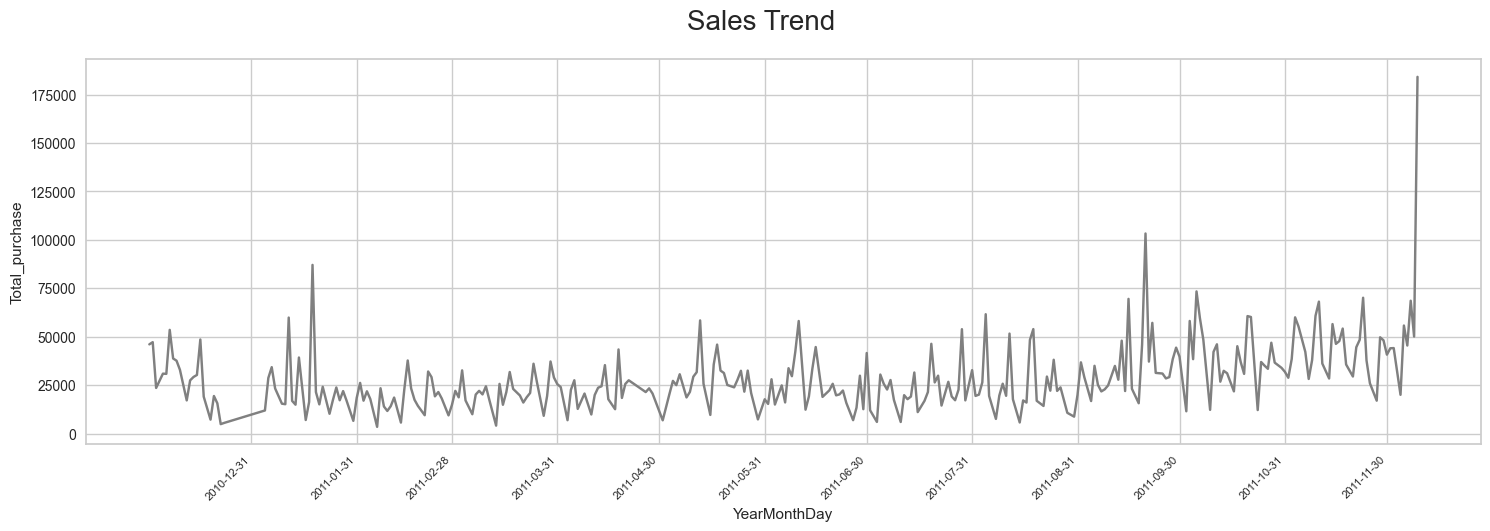

In [33]:
# 년월일 별 판매 금액 트렌드 
YearMonthDay_amount=df1.groupby('YearMonthDay')['Total_purchase'].sum().reset_index()


plt.figure(figsize=(18, 5)).suptitle('Sales Trend', fontsize=20)
sns.lineplot(x='YearMonthDay', y='Total_purchase', data=YearMonthDay_amount,color='grey')
# xticks 간격 설정
plt.xticks(YearMonthDay_amount['YearMonthDay'], rotation=45, ha='right', fontsize=8)  

# 1달 간격으로 xticks 설정
date_range = pd.date_range(start=YearMonthDay_amount['YearMonthDay'].min(), end=YearMonthDay_amount['YearMonthDay'].max(), freq='1M')
plt.xticks(date_range, [date.strftime('%Y-%m-%d') for date in date_range], rotation=45, ha='right', fontsize=8)

plt.show()


In [34]:
# 2010~2011년 기간 중, 최대 매출,최소 매출, 평균 매출 금액 확인 
print('최대 매출 :',YearMonthDay_amount['Total_purchase'].max())
print('최소 매출 :',YearMonthDay_amount['Total_purchase'].min())
print('평균 매출 :',YearMonthDay_amount['Total_purchase'].mean())

최대 매출 : 184170.66
최소 매출 : 3439.67
평균 매출 : 28642.62504918033


In [35]:
# 최대 매출 발생한 날짜 확인 
YearMonthDay_amount[YearMonthDay_amount['Total_purchase']==184170.66]

,YearMonthDay,Total_purchase
304,2011-12-09,184170.66


In [36]:
# 최대 매출 발생 전후 30일 날짜 확인 
print(YearMonthDay_amount.loc[304,'YearMonthDay']+pd.DateOffset(days=30))
print(YearMonthDay_amount.loc[304,'YearMonthDay']-pd.DateOffset(days=30))

2012-01-08 00:00:00
2011-11-09 00:00:00


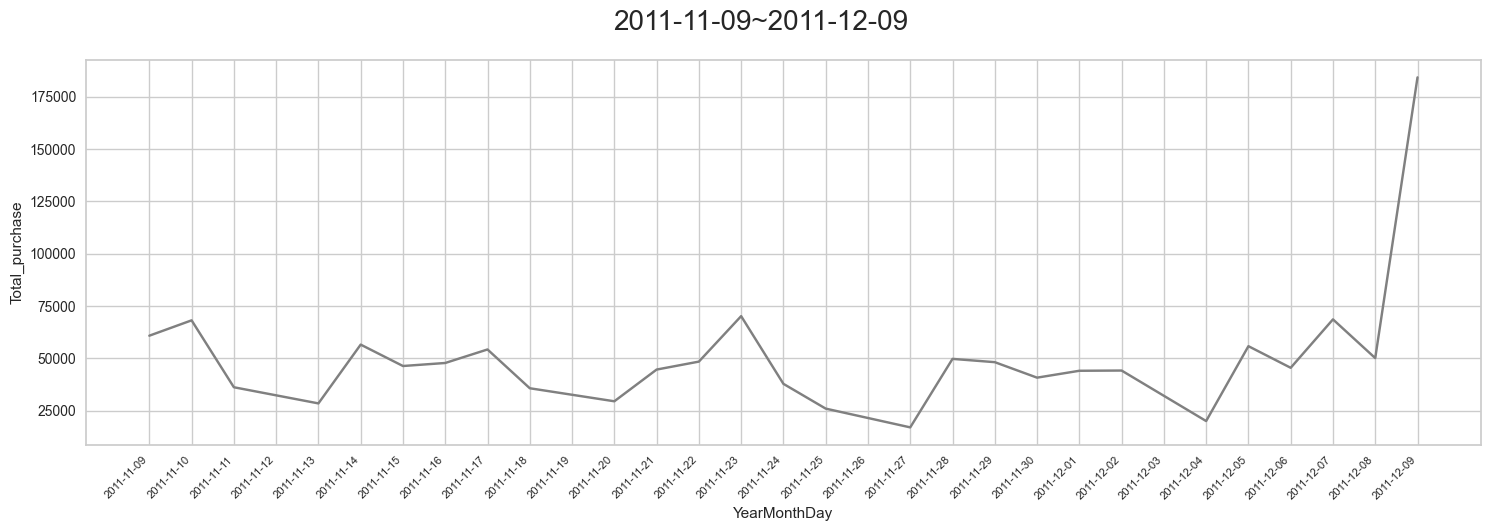

In [37]:
# 최대 매출 발생 전후 30일 판매 추세 확인 
YearMonthDay_amount['YearMonthDay']=pd.to_datetime(YearMonthDay_amount['YearMonthDay'])
period_amount=YearMonthDay_amount[(YearMonthDay_amount['YearMonthDay']>='2011-11-09')&(YearMonthDay_amount['YearMonthDay']<='2012-01-08')]


plt.figure(figsize=(18, 5)).suptitle('2011-11-09~2011-12-09', fontsize=20)
sns.lineplot(x='YearMonthDay', y='Total_purchase', data=period_amount,color='grey')
# xticks 간격 설정
plt.xticks(period_amount['YearMonthDay'], rotation=45, ha='right', fontsize=8)  

# 1달 간격으로 xticks 설정
date_range = pd.date_range(start=period_amount['YearMonthDay'].min(), end=period_amount['YearMonthDay'].max(), freq='1d')
plt.xticks(date_range, [date.strftime('%Y-%m-%d') for date in date_range], rotation=45, ha='right', fontsize=8)

plt.show()

- 최대 매출 발생일인 2011-12-09 30일 판매 추세 확인 시에도, 판매 증가가 두드러지게 증가하였다. 
=> 해당 일자에 이벤트 시행했음을 추측할 수 있다.
- 2010년 12월부터 2011년 8월까지는 안정적인 판매 추세를 보이 나, 2011년 9월~10월에 판매량이 급증했다.

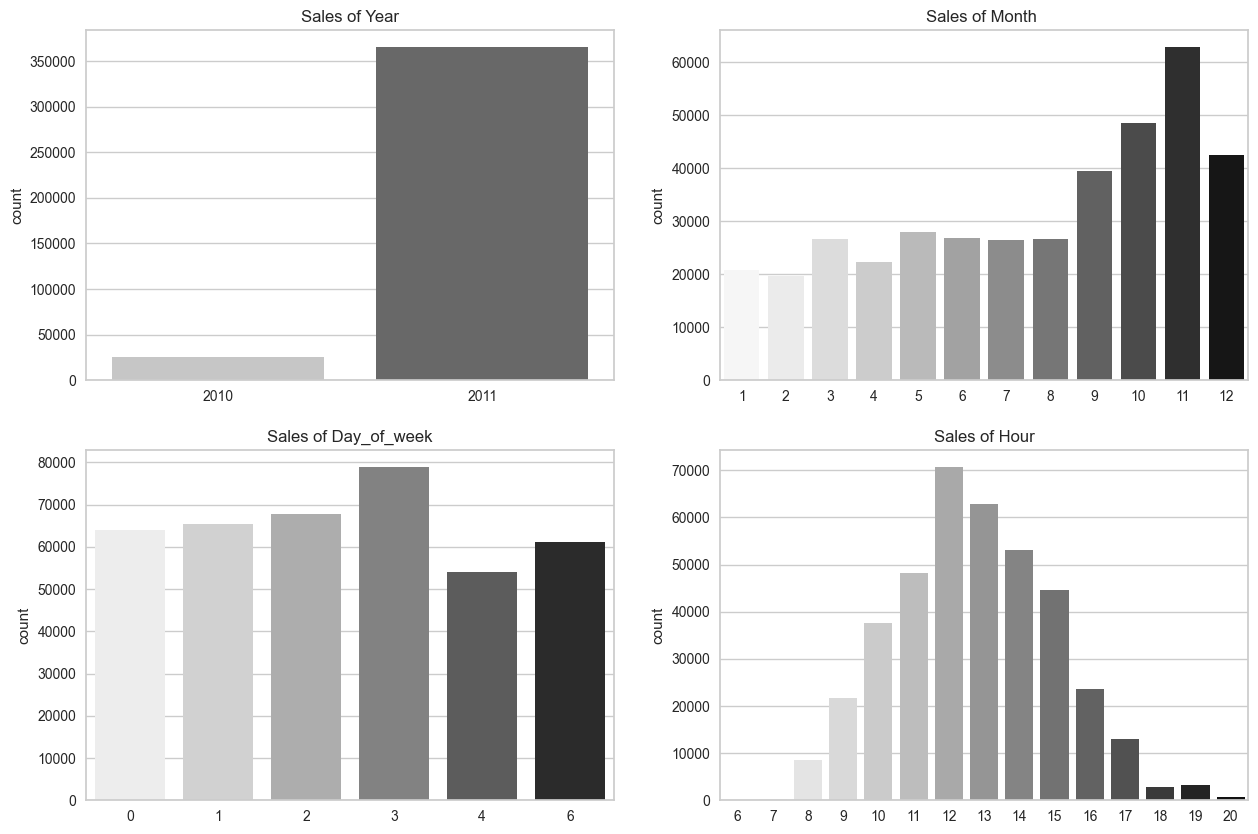

In [38]:
# 년도별, 월별, 요일별, 시간별 판매 추세 확인 

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15, 10))




sns.countplot(data=df1, x="Year", ax=ax[0, 0],palette='Greys')
ax[0, 0].set_title('Sales of Year')
ax[0, 0].set_xlabel('')
sns.countplot(data=df1, x="Month",ax=ax[0,1],palette='Greys')
ax[0, 1].set_title('Sales of Month ')
ax[0, 1].set_xlabel('')
sns.countplot(data=df1, x="Day_of_week",ax=ax[1,0],palette='Greys')
ax[1, 0].set_title('Sales of Day_of_week')
ax[1, 0].set_xlabel('')
sns.countplot(data=df1, x="Hour",ax=ax[1,1],palette='Greys')
ax[1, 1].set_title('Sales of Hour')
ax[1, 1].set_xlabel('')
plt.show()

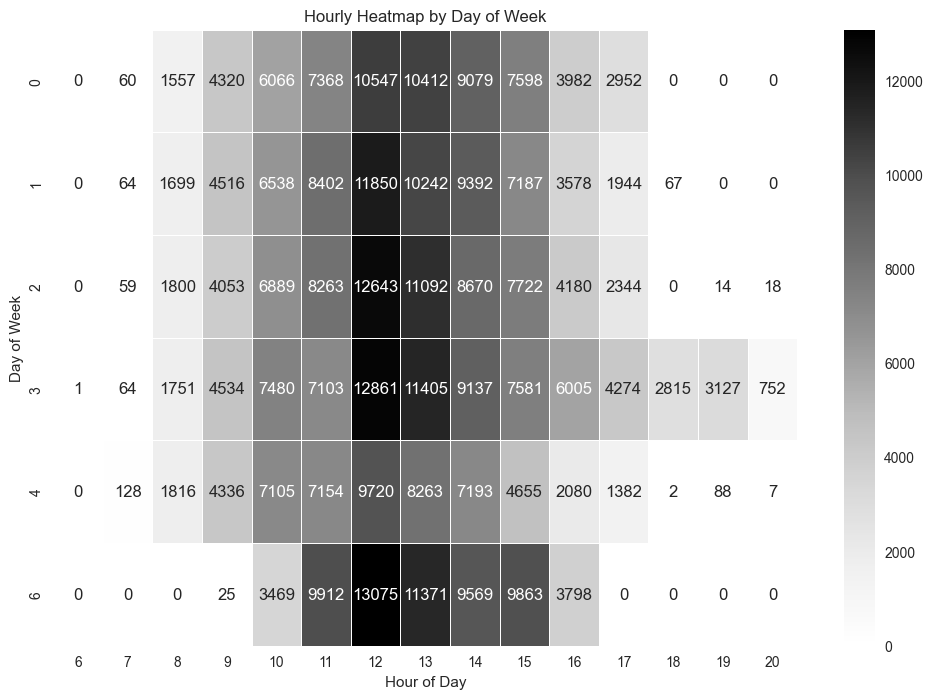

In [39]:
heatmap_data = df1.pivot_table(index='Day_of_week', columns='Hour', aggfunc='size', fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Greys', annot=True, fmt='d', linewidths=.5)
plt.title('Hourly Heatmap by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


In [40]:
# 년도별 매출 및 매출증가율 
year_amount=df1.groupby(['Year'])['Total_purchase'].sum().to_frame().T
year_amount['ratio']=((year_amount[2011]-year_amount[2010])/year_amount[2010])*100
year_amount

Year,2010,2011,ratio
Total_purchase,565199.56,8170801.08,1345.648875


In [41]:
# 년도,월별 판매 금액 
df1.groupby(['Year','Month'])['Total_purchase'].sum().to_frame()

Total_purchase
Year Month                
2010 12          565199.56
2011 1           562682.91
     2           442293.59
     3           583143.85
     4           454440.88
     5           659227.49
     6           653114.92
     7           591438.79
     8           635379.38
     9           938662.63
     10         1002203.56
     11         1136135.00
     12          512078.08

In [42]:
# 월별 판매 금액 

df1.groupby(['Month'])['Total_purchase'].sum().to_frame()

,Total_purchase
Month,
1,562682.91
2,442293.59
3,583143.85
4,454440.88
5,659227.49
6,653114.92
7,591438.79
8,635379.38
9,938662.63


- 전년도 대비 매출 증가율은 1308% 이다.=> 하지만, 2010년에는 12월 데이터만 있으며, 2011년에는 1~12월 데이터가 모두 포함되어 있다. 
- 월별 판매 추세 확인 시, 11월이 가장 많은 매출이 발생했다. 
- 시간대별 판매 추세 확인 시, 낮 12시에 가장 많은 매출이 발생했다.


## 4-2.국가별 매출액

In [43]:
top10_country=df1.groupby(['Country'])['Total_purchase'].sum().sort_values(ascending=False).reset_index().head(10)
bottom10_country=df1.groupby(['Country'])['Total_purchase'].sum().sort_values(ascending=False).reset_index().tail(10)

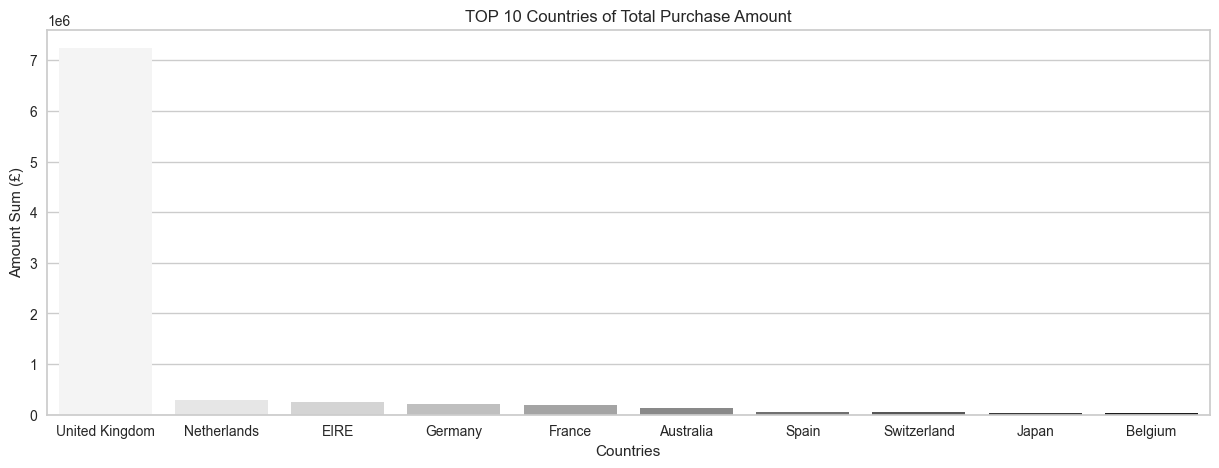

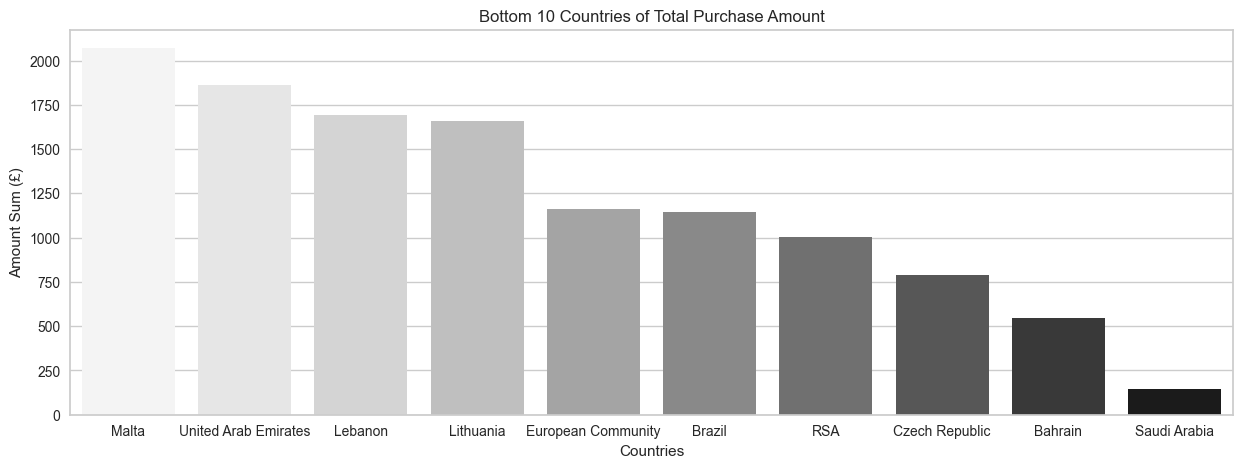

In [44]:
# TOP 10 국가별 매출액 
plt.figure(figsize=(15, 5))
sns.barplot(x='Country', y='Total_purchase', data=top10_country, palette='Greys')
plt.title('TOP 10 Countries of Total Purchase Amount')
plt.xlabel('Countries')
plt.ylabel('Amount Sum (£)')
plt.show()

# Bottom 10 국가별 매출액 
plt.figure(figsize=(15, 5))
sns.barplot(x='Country', y='Total_purchase', data=bottom10_country, palette='Greys')
plt.title('Bottom 10 Countries of Total Purchase Amount')
plt.xlabel('Countries')
plt.ylabel('Amount Sum (£)')
plt.show()

In [45]:
df1['Country'].value_counts()/df1.shape[0]

Country
United Kingdom          0.891893
Germany                 0.022098
France                  0.020505
EIRE                    0.018222
Spain                   0.006181
Netherlands             0.005938
Belgium                 0.004948
Switzerland             0.004628
Portugal                0.003621
Australia               0.003017
Norway                  0.002680
Channel Islands         0.001900
Italy                   0.001895
Finland                 0.001654
Cyprus                  0.001537
Sweden                  0.001092
Austria                 0.000982
Denmark                 0.000938
Poland                  0.000831
Japan                   0.000821
Israel                  0.000626
Unspecified             0.000616
Singapore               0.000550
Iceland                 0.000465
USA                     0.000458
Canada                  0.000384
Greece                  0.000363
Malta                   0.000279
United Arab Emirates    0.000171
European Community      0.000146
RS

- 'United Kingdom'(영국)의 판매 점유율은 약 89%로, 과반수 이상의 매출을 점유하고 있다.
- 'Saudi Arabia' (사우디 아라비아)의 판매 금액이 가장 낮으며,약 0.023%의 점유율


## 4-3.상품

In [46]:
# 상품 코드 별, 구매 빈도, 수량, 금액 확인 
stock_sale=df1.groupby(["StockCode"]).agg({"InvoiceNo": "count", 
                               "Quantity": "sum",
                               "Total_purchase": "sum"
                              })
stock_sale.head()

,InvoiceNo,Quantity,Total_purchase
StockCode,,,
10002,49,823,699.55
10080,21,291,114.41
10120,29,192,40.32
10123C,3,5,3.25
10124A,5,16,6.72


In [47]:
# stockcode별 Description 추출 
stock_desc=df1.loc[df1["StockCode"].isin(stock_sale.index), 
                    ["StockCode", "Description"]].drop_duplicates("StockCode").set_index("StockCode")
stock_desc.loc[stock_sale.index].head()

,Description
StockCode,
10002,INFLATABLE POLITICAL GLOBE
10080,GROOVY CACTUS INFLATABLE
10120,DOGGY RUBBER
10123C,HEARTS WRAPPING TAPE
10124A,SPOTS ON RED BOOKCOVER TAPE


In [48]:
# stockcode별 빈도,수량,금액,설명 데이터 프레임 완성 
stock_sale["Desc"] = stock_desc.loc[stock_sale.index]
stock_sale.head()

,InvoiceNo,Quantity,Total_purchase,Desc
StockCode,,,,
10002,49,823,699.55,INFLATABLE POLITICAL GLOBE
10080,21,291,114.41,GROOVY CACTUS INFLATABLE
10120,29,192,40.32,DOGGY RUBBER
10123C,3,5,3.25,HEARTS WRAPPING TAPE
10124A,5,16,6.72,SPOTS ON RED BOOKCOVER TAPE


In [51]:
# 구매 빈도 Top 10 stock
top_10_stock_fre=stock_sale.sort_values(by='InvoiceNo',ascending=False).head(10)

# 구매 수량 Top 10 stock
top_10_stock_quan=stock_sale.sort_values(by='Quantity',ascending=False).head(10)

# 구매 금액 Top 10 stock
top_10_stock_amount=stock_sale.sort_values(by='Total_purchase',ascending=False).head(10)

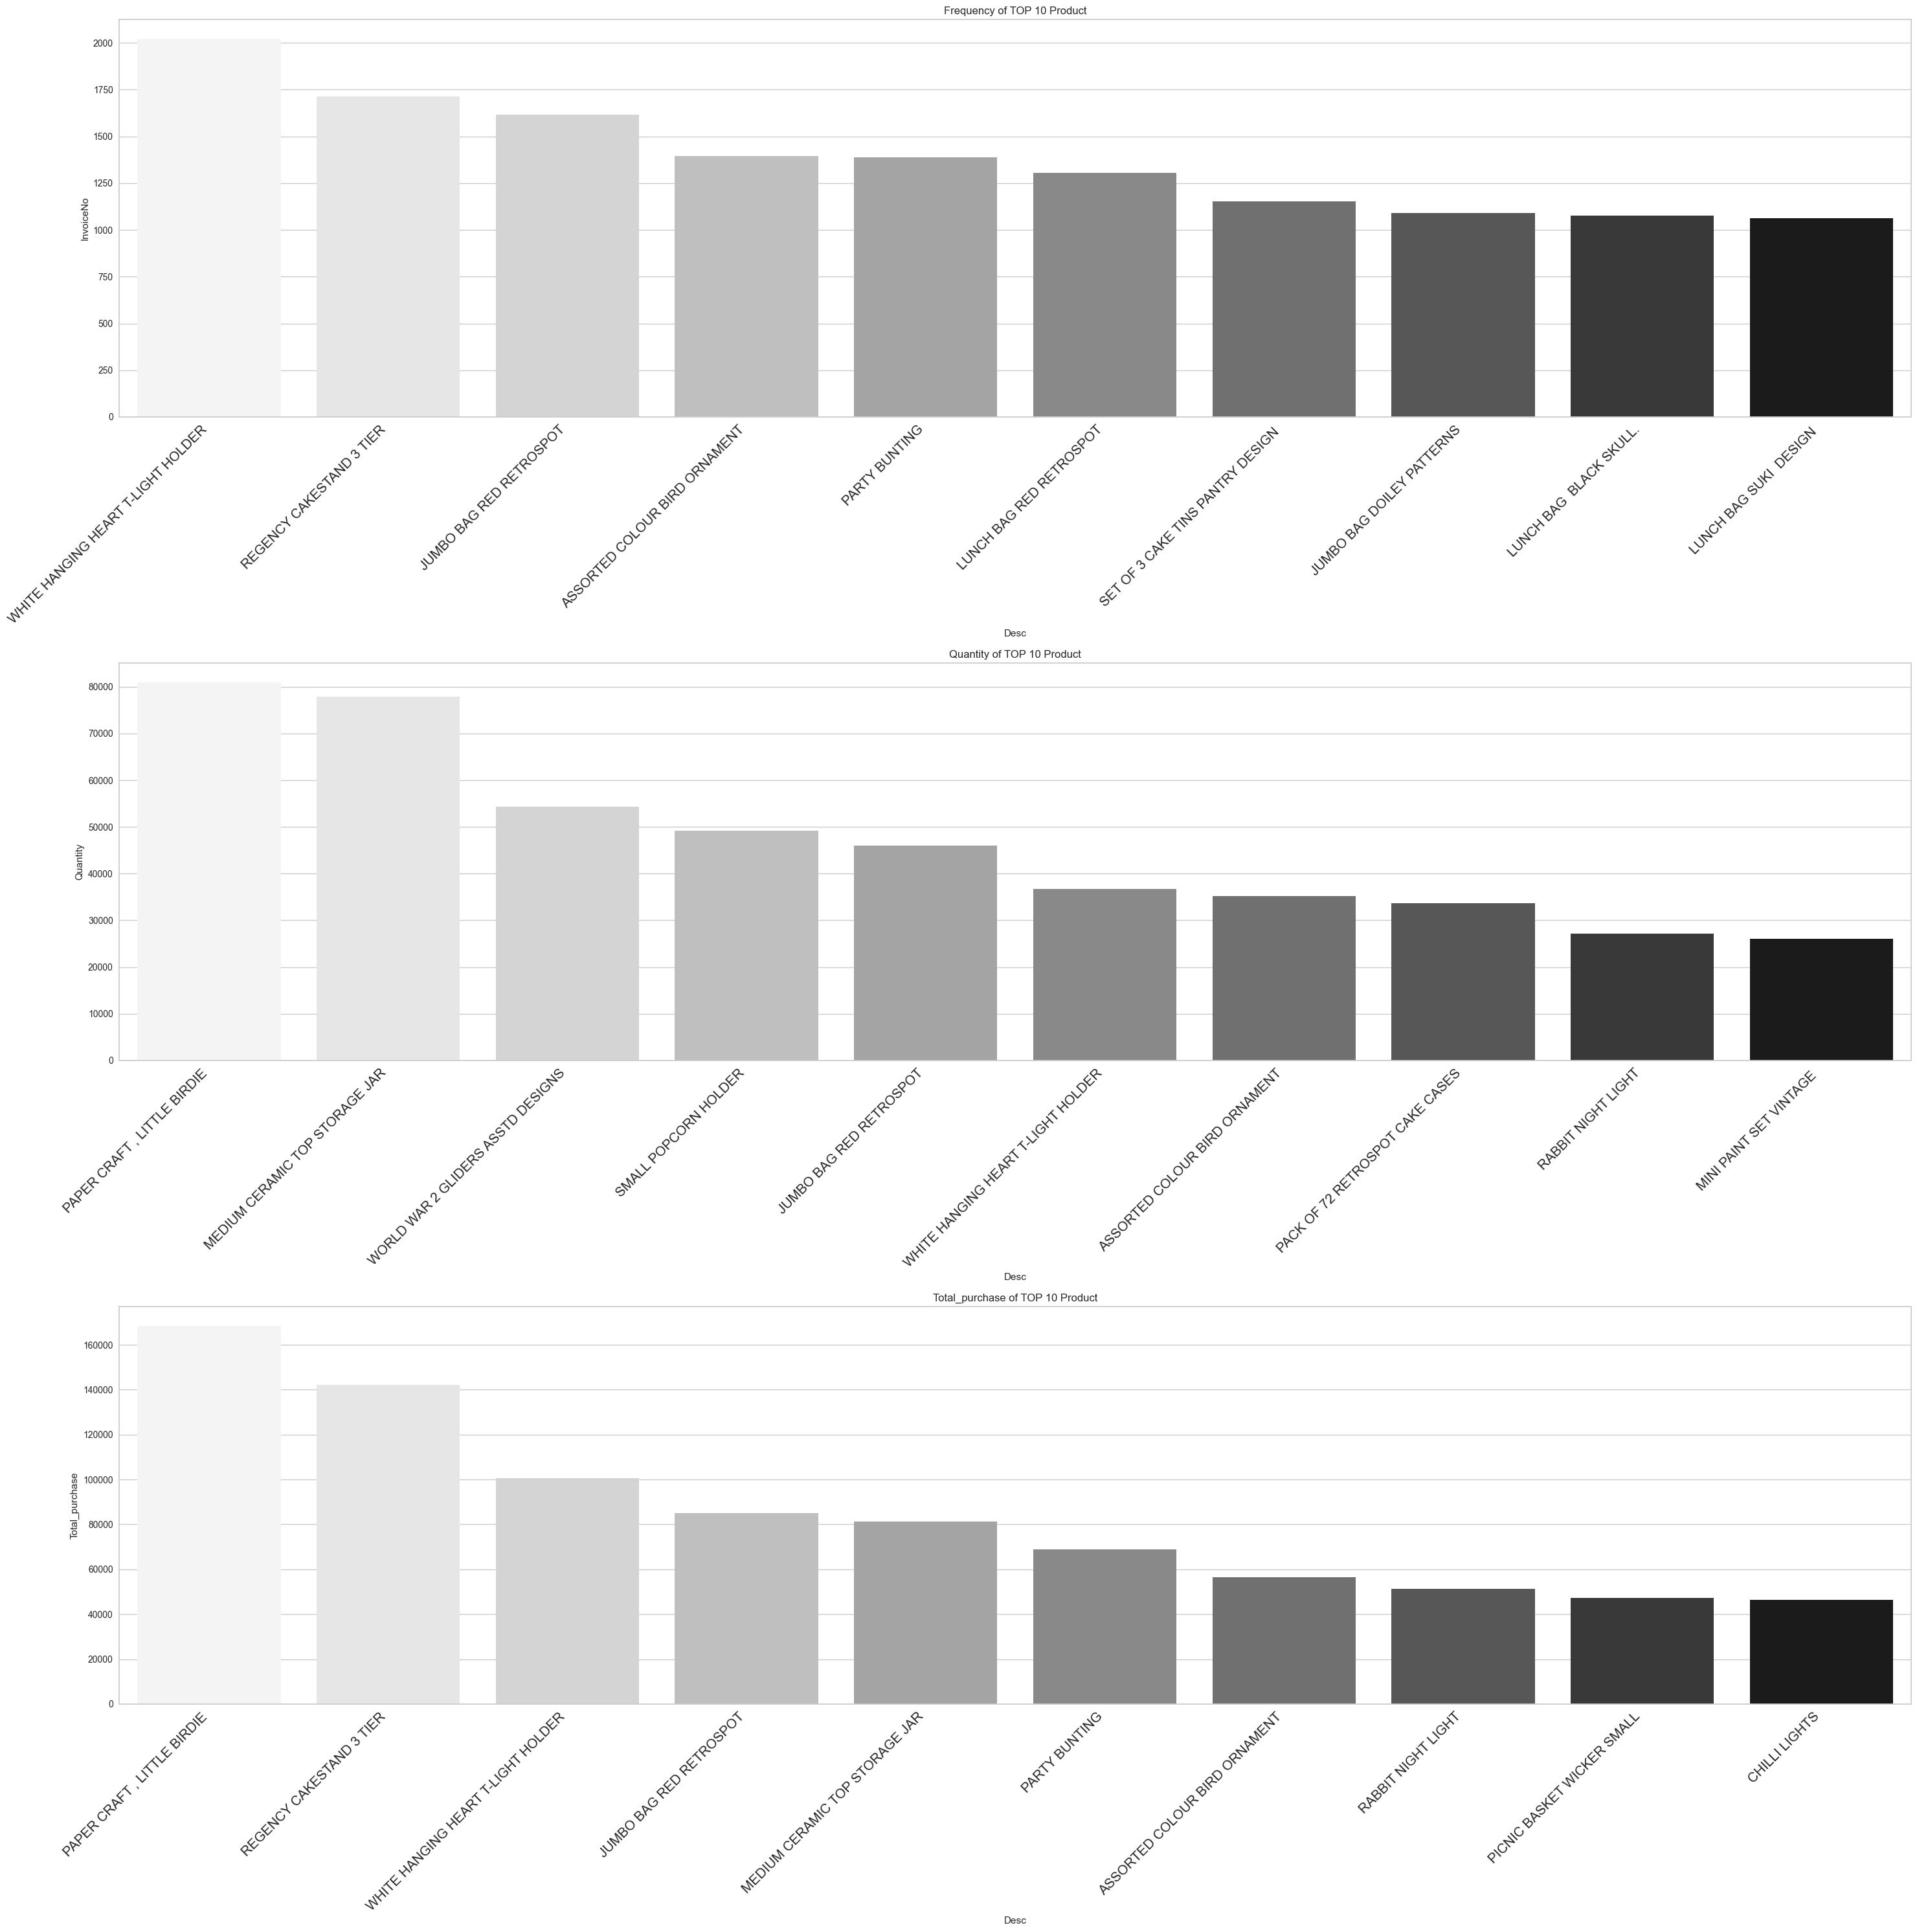

In [52]:
# 구매 빈도 Top 10 stock
fig, ax = plt.subplots(3, 1, figsize=(30, 30))  # 조정된 figsize
sns.barplot(x='Desc', y='InvoiceNo', data=top_10_stock_fre, palette='Greys', ax=ax[0])
ax[0].set_title('Frequency of TOP 10 Product')
ax[0].set_xticks(range(len(top_10_stock_fre['Desc'])))
ax[0].set_xticklabels(top_10_stock_fre['Desc'], rotation=45, ha='right', size=15)  # 조정된 size와 ha 추가

# 구매 수량 Top 10 stock
sns.barplot(x='Desc', y='Quantity', data=top_10_stock_quan, palette='Greys', ax=ax[1])
ax[1].set_title('Quantity of TOP 10 Product')
ax[1].set_xticks(range(len(top_10_stock_quan['Desc'])))
ax[1].set_xticklabels(top_10_stock_quan['Desc'], rotation=45, ha='right', size=15)  # 조정된 size와 ha 추가

# 구매 금액 Top 10 stock
sns.barplot(x='Desc', y='Total_purchase', data=top_10_stock_amount, palette='Greys', ax=ax[2])
ax[2].set_title('Total_purchase of TOP 10 Product')
ax[2].set_xticks(range(len(top_10_stock_amount['Desc'])))
ax[2].set_xticklabels(top_10_stock_amount['Desc'], rotation=45, ha='right', size=15)  # 조정된 size와 ha 추가

plt.tight_layout()  # subplot 간의 간격을 조절
plt.show()

In [53]:
# 구매 빈도 top 10 quantity_per_purchase => 구매당 수량 / amount_per_purchase => 구매당 금액 변수 추가 
top_10_stock_fre['quantity_per_purchase']=top_10_stock_fre['Quantity']/top_10_stock_fre['InvoiceNo']
top_10_stock_fre['amount_per_purchase']=top_10_stock_fre['Total_purchase']/top_10_stock_fre['Quantity']
top_10_stock_fre

,InvoiceNo,Quantity,Total_purchase,Desc,quantity_per_purchase,amount_per_purchase
StockCode,,,,,,
85123A,2023,36763,100547.45,WHITE HANGING HEART T-LIGHT HOLDER,18.172516,2.735018
22423,1713,12374,142264.75,REGENCY CAKESTAND 3 TIER,7.223584,11.497070
85099B,1615,46078,85040.54,JUMBO BAG RED RETROSPOT,28.531269,1.845578
84879,1395,35263,56413.03,ASSORTED COLOUR BIRD ORNAMENT,25.278136,1.599780
47566,1389,15279,68785.23,PARTY BUNTING,11.000000,4.501946
20725,1304,17776,28158.80,LUNCH BAG RED RETROSPOT,13.631902,1.584091
22720,1152,7010,33298.30,SET OF 3 CAKE TINS PANTRY DESIGN,6.085069,4.750114
23203,1091,19498,37646.94,JUMBO BAG DOILEY PATTERNS,17.871677,1.930810
20727,1078,11246,17950.30,LUNCH BAG BLACK SKULL.,10.432282,1.596150


In [54]:
# 구매 수량  top 10 quantity_per_purchase => 구매당 수량 / amount_per_purchase => 구매당 금액 변수 추가 
top_10_stock_quan['quantity_per_purchase']=top_10_stock_quan['Quantity']/top_10_stock_quan['InvoiceNo']
top_10_stock_quan['amount_per_purchase']=top_10_stock_quan['Total_purchase']/top_10_stock_quan['Quantity']
top_10_stock_quan

,InvoiceNo,Quantity,Total_purchase,Desc,quantity_per_purchase,amount_per_purchase
StockCode,,,,,,
23843,1,80995,168469.60,"PAPER CRAFT , LITTLE BIRDIE",80995.000000,2.080000
23166,198,77916,81416.73,MEDIUM CERAMIC TOP STORAGE JAR,393.515152,1.044930
84077,472,54319,13558.41,WORLD WAR 2 GLIDERS ASSTD DESIGNS,115.082627,0.249607
22197,1060,49160,37206.88,SMALL POPCORN HOLDER,46.377358,0.756853
85099B,1615,46078,85040.54,JUMBO BAG RED RETROSPOT,28.531269,1.845578
85123A,2023,36763,100547.45,WHITE HANGING HEART T-LIGHT HOLDER,18.172516,2.735018
84879,1395,35263,56413.03,ASSORTED COLOUR BIRD ORNAMENT,25.278136,1.599780
21212,1050,33670,16381.88,PACK OF 72 RETROSPOT CAKE CASES,32.066667,0.486542
23084,823,27153,51251.24,RABBIT NIGHT LIGHT,32.992710,1.887498


In [57]:
# 구매 금액 top 10 quantity_per_purchase => 구매당 수량 / amount_per_purchase => 구매당 금액 변수 추가 
top_10_stock_amount['quantity_per_purchase']=top_10_stock_amount['Quantity']/top_10_stock_amount['InvoiceNo']
top_10_stock_amount['amount_per_purchase']=top_10_stock_amount['Total_purchase']/top_10_stock_amount['Quantity']
top_10_stock_amount

,InvoiceNo,Quantity,Total_purchase,Desc,quantity_per_purchase,amount_per_purchase
StockCode,,,,,,
23843,1,80995,168469.60,"PAPER CRAFT , LITTLE BIRDIE",80995.000000,2.080000
22423,1713,12374,142264.75,REGENCY CAKESTAND 3 TIER,7.223584,11.497070
85123A,2023,36763,100547.45,WHITE HANGING HEART T-LIGHT HOLDER,18.172516,2.735018
85099B,1615,46078,85040.54,JUMBO BAG RED RETROSPOT,28.531269,1.845578
23166,198,77916,81416.73,MEDIUM CERAMIC TOP STORAGE JAR,393.515152,1.044930
47566,1389,15279,68785.23,PARTY BUNTING,11.000000,4.501946
84879,1395,35263,56413.03,ASSORTED COLOUR BIRD ORNAMENT,25.278136,1.599780
23084,823,27153,51251.24,RABBIT NIGHT LIGHT,32.992710,1.887498
22502,236,1485,47348.35,PICNIC BASKET WICKER SMALL,6.292373,31.884411


In [58]:
print('구매 빈도 top 10 평균 구매 수량 :',top_10_stock_fre['quantity_per_purchase'].median())
print('구매 수량 top 10 평균 구매 수량 :',top_10_stock_quan['quantity_per_purchase'].median())
print('구매 금액 top 10 평균 구매 수량 :',top_10_stock_amount['quantity_per_purchase'].median())

구매 빈도 top 10 평균 구매 수량 : 12.315950920245399
구매 수량 top 10 평균 구매 수량 : 39.68503404479699
구매 금액 top 10 평균 구매 수량 : 21.896265797095467


In [59]:
print('구매 빈도 top 10 평균 구매 금액 :',top_10_stock_fre['amount_per_purchase'].median())
print('구매 수량 top 10 평균 구매 금액 :',top_10_stock_quan['amount_per_purchase'].median())
print('구매 금액 top 10 평균 구매 금액 :',top_10_stock_amount['amount_per_purchase'].median())

구매 빈도 top 10 평균 구매 금액 : 1.8881941362960073
구매 수량 top 10 평균 구매 금액 : 1.3223545976169415
구매 금액 top 10 평균 구매 금액 : 2.4075087724070396


- 가장 자주 구매한 상품은 WHITE HANGING HEART T-LIGHT HOLDER (티라이트 홀더) 
- 가장 많이 구매한 상품은 WORLD WAR 2 GLIDERS ASSTD DESIGNS(모형 비행기) 
- 가장 매출액이 높은 상품은 REGENCY CAKESTAND 3 TIER (케이크 스텐드) 이다. => 해당상품의 가격이 가장 높은것으로 추측된다. 
- 세가지 항목 모두 공통적으로 조명,장식품 등 상품이 모두 상위 10위안에 랭크되어 있음을 알 수 있다. 

# 5.RFM 분석

In [60]:
# Monetary 피처 생성을 위해, 제품단가 x 가격으로=> 총 구매금액 컬럼 생성 
# df1['Total_purchase']=df['Quantity']*df1['UnitPrice']

# Recency 계산을 위해 가장 최근 구매일 확인 
recent_timestamp=df1['InvoiceDate'].max()+dt.timedelta(days=1)
recent_timestamp

Timestamp('2011-12-10 12:50:00')

In [61]:
# 고객별 Recency,Frequency,Monetary 구하기

rfm=df1.groupby('CustomerID').agg(
    {'InvoiceDate':lambda x:(recent_timestamp-x.max()).days,
     'InvoiceNo':'count',
     'Total_purchase':'sum'})

# 컬럼명 변경하기 
rfm.rename(columns={'InvoiceDate':'Recency',
            'InvoiceNo':'Frequency',
            'Total_purchase':'Monetary'},inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,27,1437.24
12349.0,19,72,1457.55
12350.0,310,16,294.40


In [62]:
# 고객별 Recency,Frequency,Monetary score 생성하기
# Recency는 최근일수록 , 높은 점수 부여
r_labels=range(5,0,-1)
# Frequency,Monetary는 값이 클 수록 높은 점수 부여
f_labels=range(1,6)
m_labels=range(1,6)
rfm['Recency_score']=pd.qcut(rfm['Recency'],5,labels=r_labels)
rfm['Frequency_score']=pd.qcut(rfm['Frequency'],5,labels=f_labels)
rfm['Monetary_score']=pd.qcut(rfm['Monetary'],5,labels=m_labels)
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,27,1437.24,2,2,4
12349.0,19,72,1457.55,4,4,4
12350.0,310,16,294.40,1,2,2


In [63]:
# RFM score 생성
rfm['RFM_score']=rfm['Recency_score'].astype(int)*100+rfm['Frequency_score'].astype(int)*10+rfm['Monetary_score'].astype(int)
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,182,4310.00,5,5,5,555
12348.0,75,27,1437.24,2,2,4,224
12349.0,19,72,1457.55,4,4,4,444
12350.0,310,16,294.40,1,2,2,122


In [64]:
# RFM_score을 10 개로 나누기
pd.qcut(rfm['RFM_score'],10).value_counts().sort_values(ascending=False)

RFM_score
(231.0, 311.0]      488
(333.0, 411.0]      454
(443.0, 511.0]      444
(511.0, 545.0]      442
(188.6, 231.0]      438
(110.999, 121.0]    436
(121.0, 188.6]      431
(411.0, 443.0]      412
(545.0, 555.0]      405
(311.0, 333.0]      384
Name: count, dtype: int64

In [65]:
# RFM score에 따른 고객 segment 분류 함수
def customer_segment(cols):
    if cols >= 545:
        return 'VIP'
    elif cols >=512 and cols < 545:
        return 'Loyal customer'
    elif cols >=444 and cols < 512:
        return 'Potential Loyalists'
    elif cols >=411 and cols < 444:
        return 'New customers'
    elif cols >=333 and cols < 411:
        return 'Promising'
    elif cols >=311 and cols < 333:
        return 'Need Attention'
    elif cols >=232 and cols < 311:
        return 'About To Sleep'
    elif cols >=211 and cols < 232:
        return 'Cannot lose them'
    elif cols >=121 and cols < 211:
        return 'At-Risk'
    else:
        return 'Hibernating'
rfm['RFM_segment']=rfm['RFM_score'].apply(customer_segment)
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_score,RFM_segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Hibernating
12347.0,2,182,4310.00,5,5,5,555,VIP
12348.0,75,27,1437.24,2,2,4,224,Cannot lose them
12349.0,19,72,1457.55,4,4,4,444,Potential Loyalists
12350.0,310,16,294.40,1,2,2,122,At-Risk


## 5-1.세그먼트 분석 

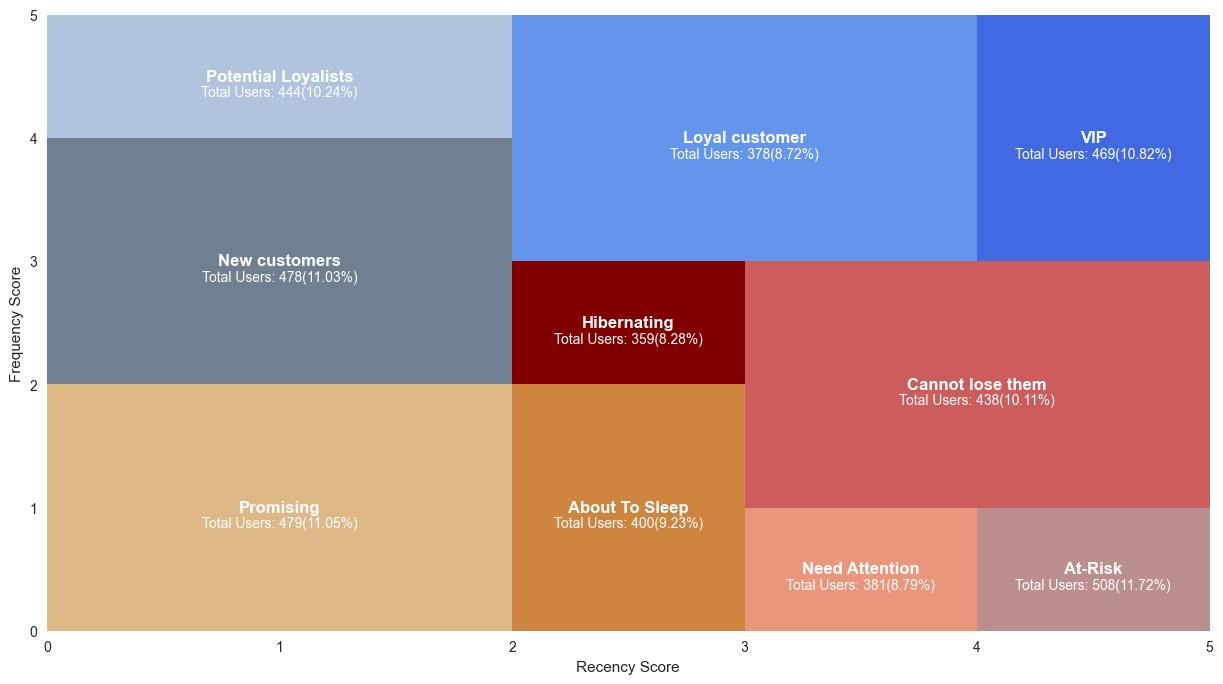

In [66]:
# 세그먼트별 좌표 설정
rfm_coordinates = {"VIP": [3, 5, 0.8, 1],
                   "Loyal customer": [3, 5, 0.4, 0.8],
                   "Potential Loyalists": [4, 5, 0, 0.4],
                   "New customers": [2, 4, 0, 0.4],
                   "Promising": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Need Attention": [0, 1, 0.6, 0.8],
                   "At-Risk": [0, 1, 0.8, 1],
                   "Cannot lose them": [1, 3, 0.6, 1],
                   "Hibernating": [2, 3, 0.4, 0.6]}

fig, ax = plt.subplots(figsize=(15, 8))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

# palette를 10개로 수정
palette = ["royalblue", "cornflowerblue", "lightsteelblue", "slategrey", "burlywood",
           "peru", "darksalmon", "rosybrown", "indianred", "maroon"]


for key, color in zip(rfm_coordinates.keys(), palette):

    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]

    ax.axhspan(ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, facecolor=color)

    users = rfm[rfm.RFM_segment == key].shape[0]
    users_percentage = (rfm[rfm.RFM_segment == key].shape[0] / rfm.shape[0]) * 100
    avg_monetary = rfm[rfm.RFM_segment == key]["Monetary"].mean()

    user_txt = "\n\nTotal Users: " + str(users) + "(" + str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))

    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2

    plt.text(x=x, y=y, s=key, ha="center", va="center", fontsize=12, color="white", fontweight="bold")
    plt.text(x=x, y=y, s=user_txt, ha="center", va="center", fontsize=10, color="white")

ax.set_xlabel("Recency Score")
ax.set_ylabel("Frequency Score")

sns.despine(left=True, bottom=True)
plt.show()


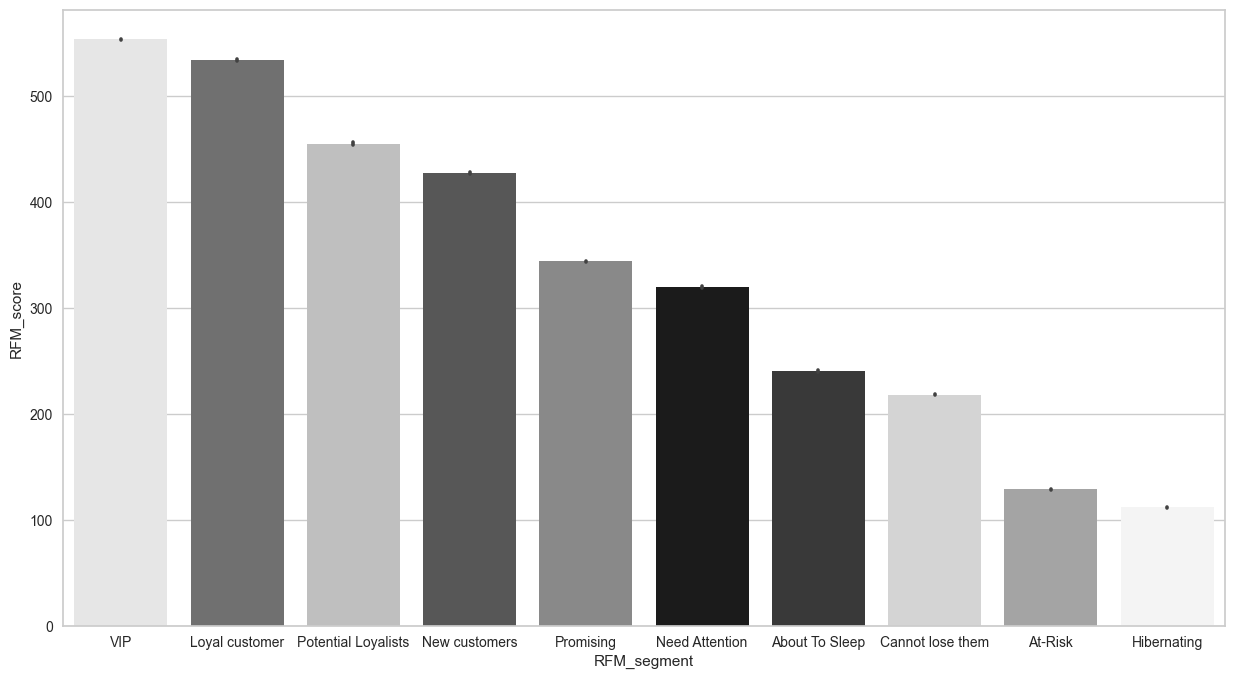

In [67]:
fig,ax=plt.subplots(figsize=(15,8))
sns.barplot(data=rfm, x="RFM_segment", y="RFM_score",ax=ax,palette='Greys',hue='RFM_segment',legend=False,
            order=['VIP','Loyal customer','Potential Loyalists','New customers','Promising','Need Attention','About To Sleep','Cannot lose them',
                  'At-Risk','Hibernating'])
plt.show()


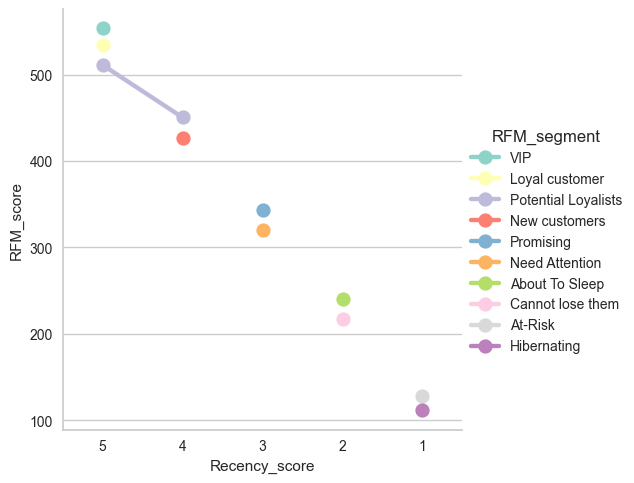

In [68]:
# RFM segment별 평균 Recency score,RFM score
sns.catplot(x='Recency_score',y='RFM_score',hue='RFM_segment',data=rfm,kind='point',palette='Set3',
           hue_order=['VIP','Loyal customer','Potential Loyalists','New customers','Promising','Need Attention','About To Sleep','Cannot lose them',
                  'At-Risk','Hibernating'])
plt.show()

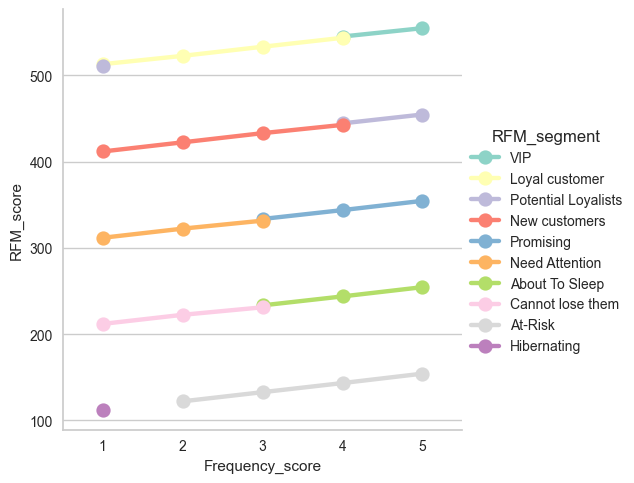

In [69]:
# RFM segment별 평균 Frequency score,RFM score
sns.catplot(x='Frequency_score',y='RFM_score',hue='RFM_segment',data=rfm,kind='point',palette='Set3',
           hue_order=['VIP','Loyal customer','Potential Loyalists','New customers','Promising','Need Attention','About To Sleep','Cannot lose them',
                  'At-Risk','Hibernating'])
plt.show()

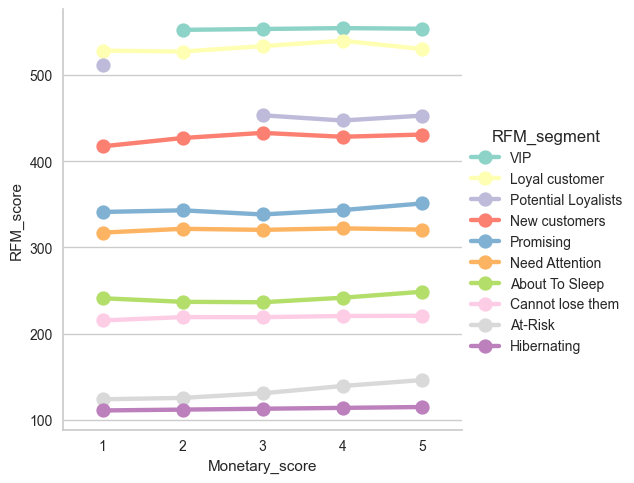

In [70]:
# RFM segment별 평균 Monetary score,RFM score
sns.catplot(x='Monetary_score',y='RFM_score',hue='RFM_segment',data=rfm,kind='point',palette='Set3',
            hue_order=['VIP','Loyal customer','Potential Loyalists','New customers','Promising','Need Attention','About To Sleep','Cannot lose them',
                  'At-Risk','Hibernating'])
plt.show()

In [71]:
print('Recency 평균 :',rfm['Recency'].mean())
print('Frequency 평균 :',rfm['Frequency'].mean())
print('Monetary 평균 :',rfm['Monetary'].mean())

Recency 평균 : 92.70304568527919
Frequency 평균 : 90.23257960313798
Monetary 평균 : 2015.6900415320722


In [72]:
# RFM segment별 통계분석 
agg_list=["mean", "count", "sum",]
result=rfm[["RFM_segment", "Recency", "Frequency", "Monetary"]].groupby("RFM_segment").agg(agg_list).round()
# 원하는 순서대로 인덱스를 재정렬
desired_order = ['VIP', 'Loyal customer', 'Potential Loyalists', 'New customers', 'Promising', 'Need Attention', 'About To Sleep', 'Cannot lose them', 'At-Risk', 'Hibernating']
result = result.reindex(desired_order)

# 재정렬된 데이터프레임 출력
result

Recency               Frequency               Monetary  \
                       mean count     sum      mean count     sum     mean   
RFM_segment                                                                  
VIP                     6.0   469    2794     344.0   469  161416   8568.0   
Loyal customer          7.0   378    2532      51.0   378   19337   1602.0   
Potential Loyalists    22.0   444    9670     169.0   444   75034   3265.0   
New customers          23.0   478   11134      36.0   478   17015    634.0   
Promising              52.0   479   24669     106.0   479   50719   1880.0   
Need Attention         53.0   381   20377      19.0   381    7364    435.0   
About To Sleep        113.0   400   45319      79.0   400   31439   1340.0   
Cannot lose them      119.0   438   52275      16.0   438    6804    457.0   
At-Risk               263.0   508  133679      38.0   508   19481    595.0   
Hibernating           277.0   359   99326       7.0   359    2459    709.0   

                                      
                    count        sum  
RFM_segment                           
VIP                   469  4018366.0  
Loyal customer        378   605459.0  
Potential Loyalists   444  1449680.0  
New customers         478   303040.0  
Promising             479   900498.0  
Need Attention        381   165806.0  
About To Sleep        400   536183.0  
Cannot lose them      438   200296.0  
At-Risk               508   302045.0  
Hibernating           359   254627.0

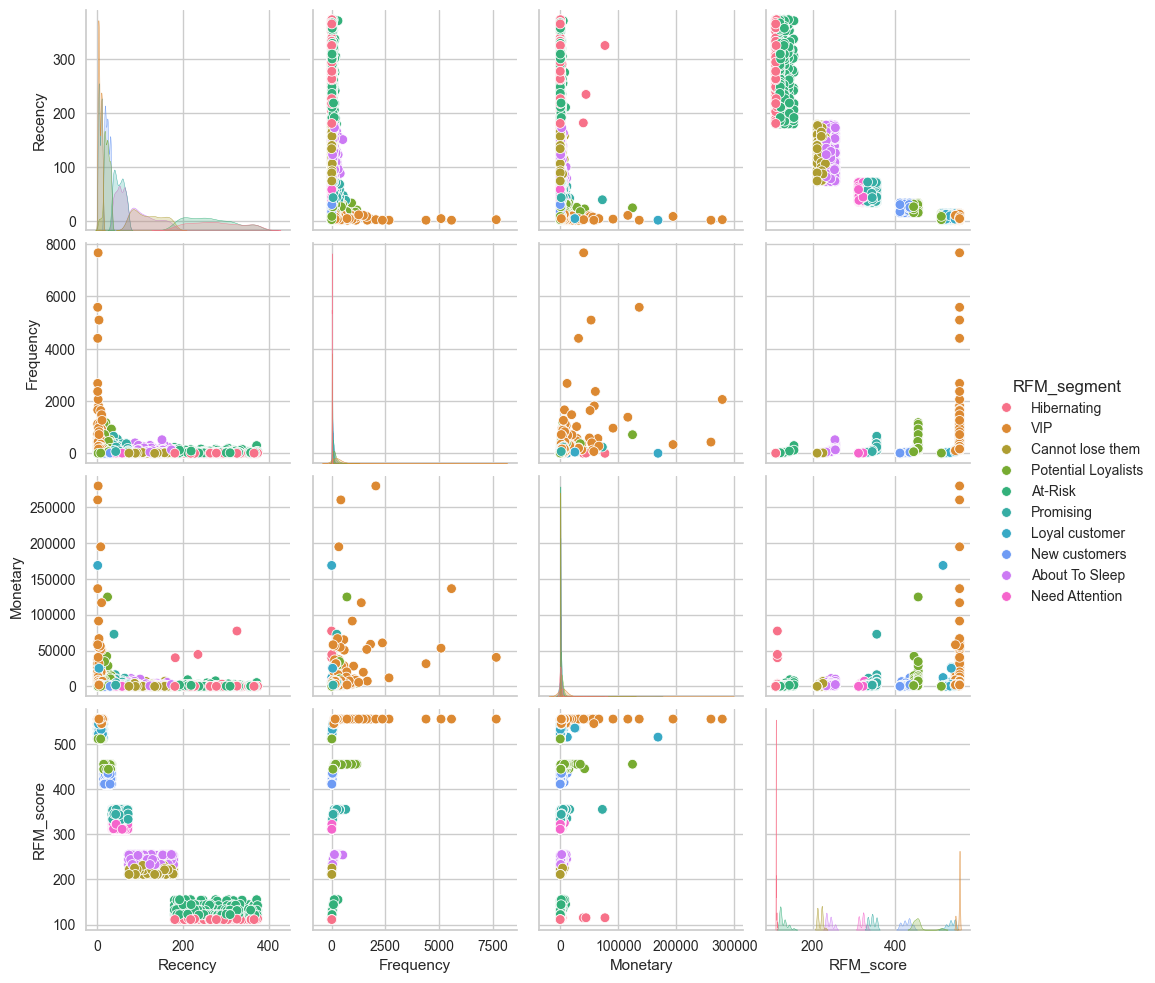

In [73]:
sns.pairplot(data=rfm, hue="RFM_segment")


###  RFM 분석 
- VIP:	가장 최근 활동/ 가장 높은 구매 빈도 /가장 높은 구매금액 (높은 가치 창출 고객)
- Loyal custoemr:	최근 활동 /VIP에 비해 낮은 구매 빈도/ VIP에 비해 낮은 금액 소진   (충성도 높은 고객)
- Potential Loyalists: 	상대적으로 최근 구매 /높은 구매 빈도/ 높은 구매 금액  (잠재적 고객)
- New customers: 	최근 유입/ 낮은 빈도/낮은 구매 금액 (신규 고객)
- Promising: 	평균적인 최근성/평균 빈도/평균 구매 금액 (가치를 높일 가능성 있는 고객)
- Need Attention: 	낮은 구매 빈도/낮은 구매 금액  (관심이 필요한 고객)
- About To Sleep:	활동은 있었지만, 더 이상 활발하지 않은 고객 (잠들기 직전 고객)
- Cannot lose them: 평균 이하 최근성/낮은 구매 빈도/평균 구매 금액 값을 가진 고객(잃을수 없는 고객)
- At-Risk: 	낮은 최근성/낮은 구매 빈도/평균 구매 금액 값을 가진 고객 (이탈 위험 고객)
- Hibernating:	가장 낮은 최근성/가장 낮은 빈도를 가진 고객 

# 6.K-means 클러스터링 -고객 세분화 

In [74]:
# k-means 클러스터링을 위해 r,f,m컬럼만 추출 
rfm1=rfm[['Recency','Frequency','Monetary']]
X_features=rfm[['Recency','Frequency','Monetary']].values
X_features

array([[3.26000e+02, 1.00000e+00, 7.71836e+04],
       [2.00000e+00, 1.82000e+02, 4.31000e+03],
       [7.50000e+01, 2.70000e+01, 1.43724e+03],
       ...,
       [8.00000e+00, 1.20000e+01, 1.78050e+02],
       [4.00000e+00, 7.19000e+02, 2.03958e+03],
       [4.30000e+01, 7.00000e+01, 1.83728e+03]])

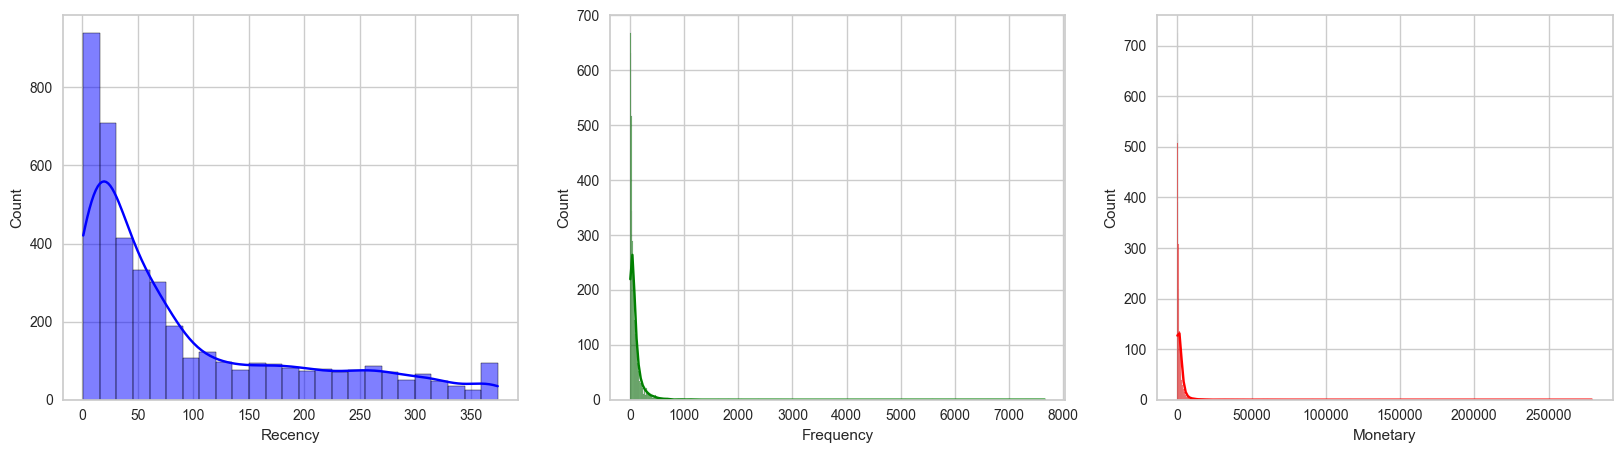

In [75]:
# 피처 분포 확인 
fig, axs = plt.subplots( 1 , 3 , figsize=( 20 , 5 )) 
sns.histplot(data=rfm, x= 'Recency' , kde= True , color= 'blue' , ax=axs[ 0 ]) 
sns.histplot(data=rfm, x= 'Frequency' , kde= True , color= 'green' , ax=axs[ 1 ]) 
sns.histplot(data=rfm, x= 'Monetary' , kde= True , color= 'red' , ax=axs[ 2 ]) 
plt.show()

## 6-0 로그변환 

In [76]:
rfm_cluster_log = np.log1p(X_features)
rfm_cluster_log

array([[ 5.78996017,  0.69314718, 11.25395523],
       [ 1.09861229,  5.20948615,  8.36892517],
       [ 4.33073334,  3.33220451,  7.27117542],
       ...,
       [ 2.19722458,  2.56494936,  5.1876651 ],
       [ 1.60943791,  6.57925121,  7.62098936],
       [ 3.78418963,  4.26267988,  7.51658563]])

## 6-1.스케일링

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(rfm_cluster_log), columns=rfm1.columns)
X

,Recency,Frequency,Monetary
0,1.460438,-2.433134,3.727721
1,-2.038956,1.191524,1.429184
2,0.371964,-0.315118,0.554595
3,-0.623847,0.453945,0.565767
4,1.423017,-0.715591,-0.706476
...,...,...,...
4329,1.342024,-1.064962,-1.094095
4330,1.023361,-1.320542,-1.729301
4331,-1.219474,-0.930890,-1.105362
4332,-1.657919,2.290850,0.833296


## 6-2.Best 클러스터 찾기 

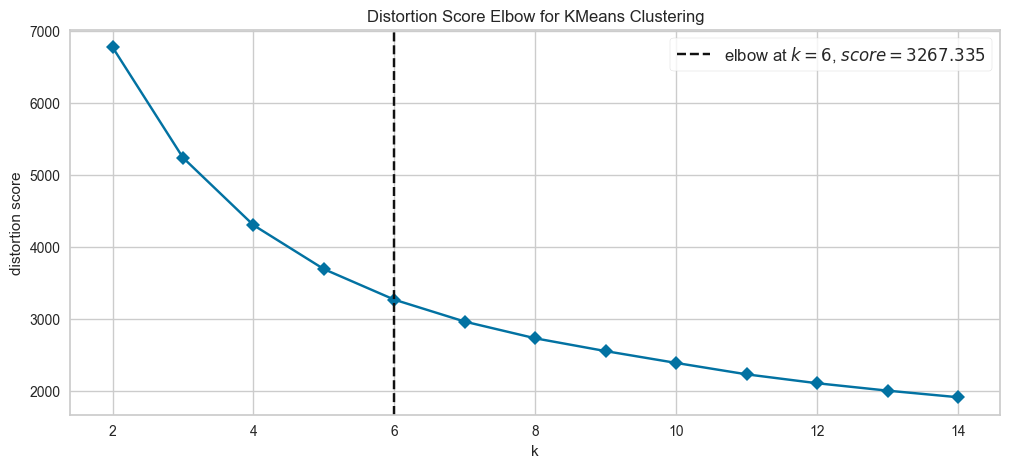

In [78]:
# Elbow Method를 통해 클러스터링에서 적절한 클러스터 수를 결정 

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12, 5))

visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax,colors='grey')

visualizer.fit(X)

visualizer.show();

## 6-3.클러스터링 

In [79]:
from sklearn.cluster import KMeans

# fit model
km = KMeans(n_clusters=4,init='k-means++', n_init=10, max_iter=100, random_state=0)
labels=km.fit_predict(X)

labels


array([2, 3, 2, ..., 0, 3, 2], dtype=int32)

In [80]:
cluster_frequencies = Counter(km.labels_)
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}
label_mapping = {v: k for k, v in {0:1, 1:2, 2:0, 3:3 }.items()}
new_labels = np.array([label_mapping[label] for label in km.labels_])

In [81]:
Counter(km.labels_)

Counter({2: 1209, 3: 863, 1: 1378, 0: 884})

In [84]:
rfm.loc[:, 'Cluster'] = new_labels.copy()
X.loc[:, 'Cluster'] = new_labels.copy()
rfm1.loc[:, 'Cluster'] = new_labels.copy()

rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_score,RFM_segment,Cluster
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Hibernating,1.0
12347.0,2,182,4310.00,5,5,5,555,VIP,3.0
12348.0,75,27,1437.24,2,2,4,224,Cannot lose them,1.0
12349.0,19,72,1457.55,4,4,4,444,Potential Loyalists,1.0
12350.0,310,16,294.40,1,2,2,122,At-Risk,0.0


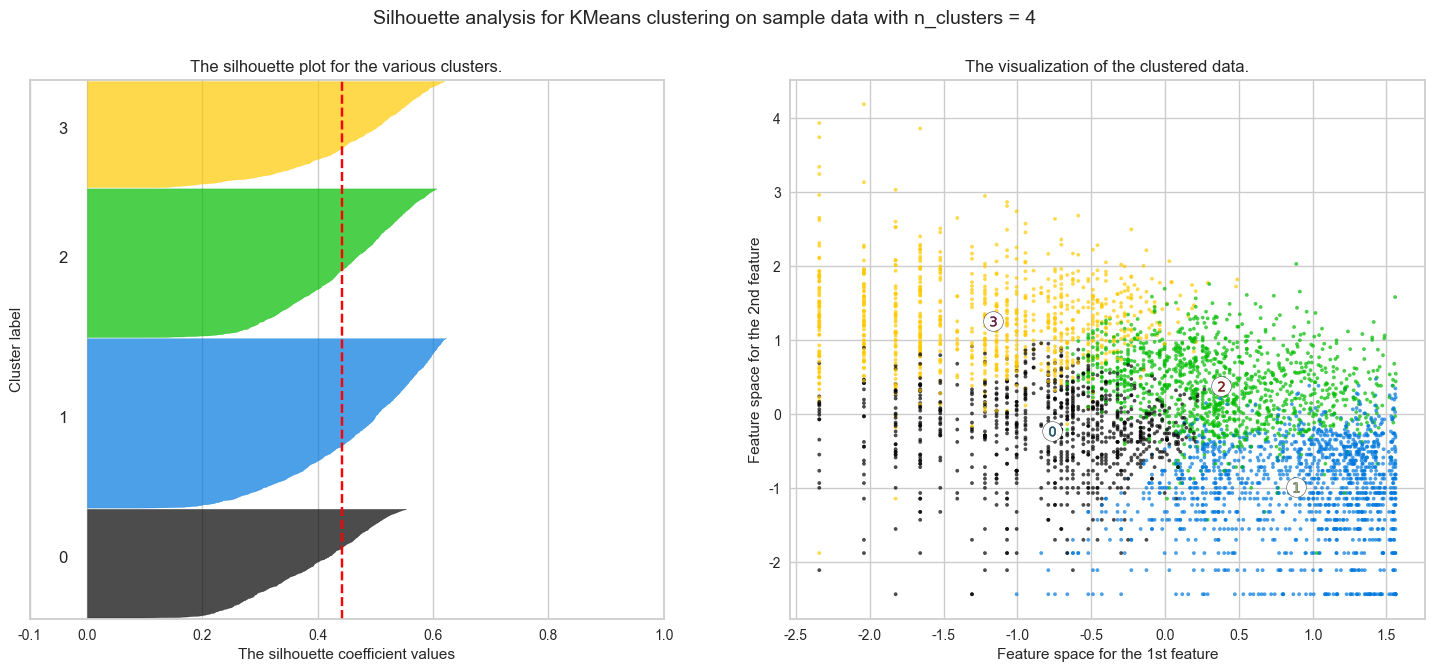

In [85]:
silhouette_avg = silhouette_score(X, km.labels_)
n_clusters=4

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
cluster_labels = km.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

centers = km.cluster_centers_
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,

)

plt.show()

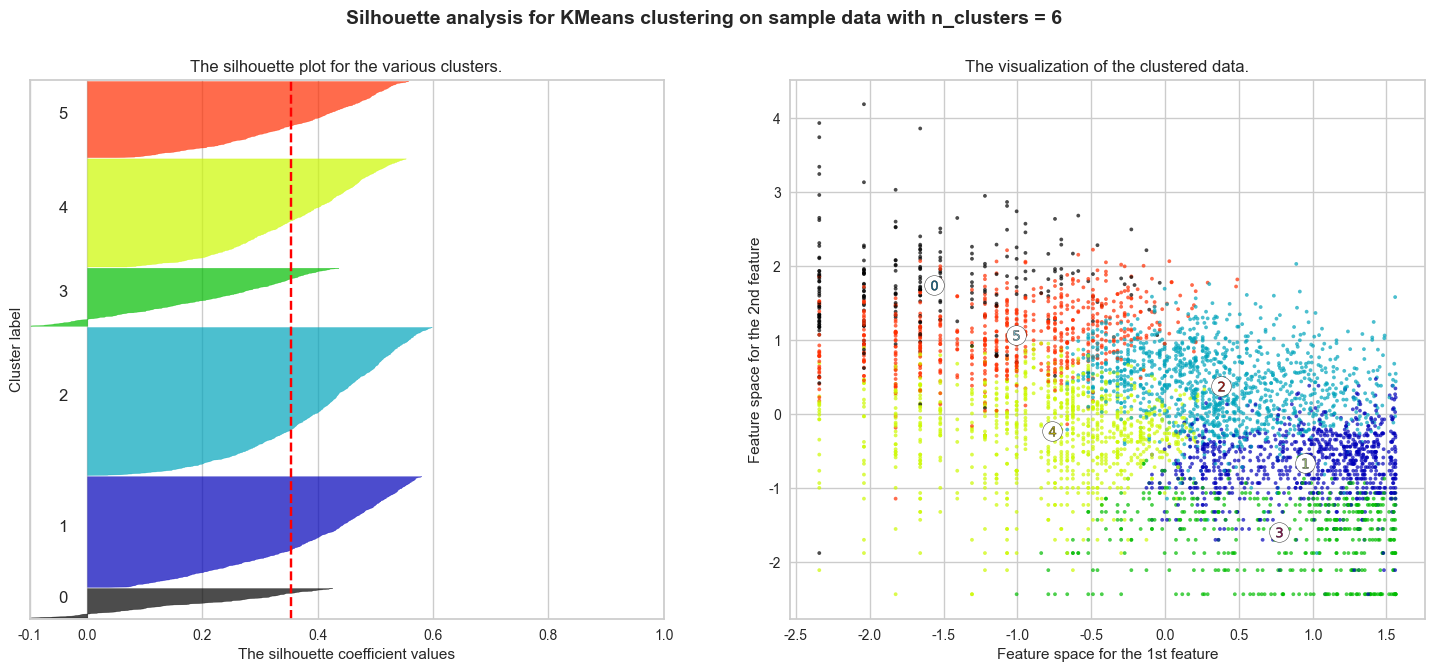

In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# assuming X is your data
# n_clusters is the desired number of clusters (in this case, 6)
n_clusters = 6
km = KMeans(n_clusters=n_clusters)
km.fit(X)

silhouette_avg = silhouette_score(X, km.labels_)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

cluster_labels = km.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

centers = km.cluster_centers_
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()


## 6-4.평가

In [87]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2, 10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=123)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure(figsize=(5, 4))
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='Greys')
    plt.tight_layout()
    plt.title('Silhouette Score of K-means Clustering')
    plt.show()


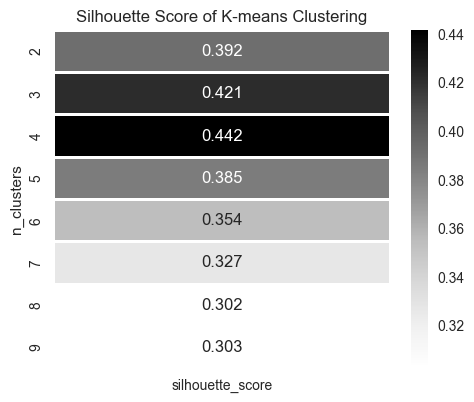

In [88]:
visualize_silhouette_layer(X)


- Silhouette Score는 k-means 클러스터링에서 각 데이터 포인트의 군집화 품질을 측정하는 지표입니다.
- cluster 46이 다른 클러스터 수보다 더 높다는 것은, 해당 클러스터링이 더 나은 품질을 갖는다는 것을 나타냅니다.
- lbow Method : 6 / Silhoutette Score: 4
- 두 지표를 함께 고려하여, 클러스터 개수  4 선택 =>클러스터 4개로 분류했을때, 실루엣 계수는 0.442로 가장 높으며, 개별 군집의 평균 실루엣 계수 값이 비교적 균일하다. 

# 7.클러스터 분석 

In [89]:
rff=rfm.reset_index()
rff=rfm.iloc[:,[0,1,2,7,8]]
final_df=df1.merge(rff,on='CustomerID',how='left')

In [90]:
# 클러스터 별 특성 분석 (클러스터의 주문 건수,총 구매액 등의 통계량 분석 ) 
cluster_describe=final_df.groupby('Cluster').agg({'InvoiceNo': 'count', 'Total_purchase': 'sum','Quantity':'sum'})
cluster_describe['quantity per Purchase']=cluster_describe['Quantity']/cluster_describe['InvoiceNo']
cluster_describe['amount per Purchase']=cluster_describe['Total_purchase']/cluster_describe['InvoiceNo']
cluster_describe.rename(columns={'InvoiceNo':'total_orders','Quantity':'total_quantity','Total_purchase':'total_purchase'},inplace=True)

In [91]:
cluster_describe

,total_orders,total_purchase,total_quantity,quantity per Purchase,amount per Purchase
Cluster,,,,,
0.0,20505,404552.29,257737,12.569471,19.729446
1.0,96201,1818495.48,1110483,11.543362,18.903083
2.0,33521,532492.24,330462,9.858357,15.885333
3.0,240841,5980460.63,3443019,14.295818,24.831572


In [92]:
# 클러스터 별 구매 패턴 

In [93]:
# 클러스터별 best 상품 top 5
cluster_product=final_df.groupby(['Cluster','Description'])['Quantity'].size().reset_index(name='cnt').sort_values(by=['Cluster','cnt'],ascending=[True,False])
cluster_product.groupby('Cluster').head(5)

,Cluster,Description,cnt
2752,0.0,WHITE HANGING HEART T-LIGHT HOLDER,160
2053,0.0,REGENCY CAKESTAND 3 TIER,138
1752,0.0,PARTY BUNTING,116
164,0.0,ASSORTED COLOUR BIRD ORNAMENT,92
2088,0.0,REX CASH+CARRY JUMBO SHOPPER,81
6199,1.0,WHITE HANGING HEART T-LIGHT HOLDER,573
5347,1.0,REGENCY CAKESTAND 3 TIER,476
3083,1.0,ASSORTED COLOUR BIRD ORNAMENT,415
4988,1.0,PARTY BUNTING,383
4467,1.0,JUMBO BAG RED RETROSPOT,348


In [94]:
# 클러스터별 판매량 TOP MONTH 5
cluster_month=final_df.groupby(['Cluster','Month'])['InvoiceNo'].size().reset_index(name='cnt').sort_values(by=['Cluster','cnt'],ascending=[True,False])
cluster_month.groupby('Cluster').head(5)

,Cluster,Month,cnt
2,0.0,3,2437
11,0.0,12,2353
9,0.0,10,2219
3,0.0,4,1945
8,0.0,9,1897
21,1.0,10,13642
20,1.0,9,10993
16,1.0,5,8144
14,1.0,3,7779
19,1.0,8,7674


In [95]:
# 클러스터별 판매량 TOP hour 5
cluster_dayh_of_week_hour=final_df.groupby(['Cluster','Day_of_week','Hour'])['InvoiceNo'].size().reset_index(name='cnt').sort_values(by=['Cluster','cnt'],ascending=[True,False])
cluster_dayh_of_week_hour.groupby('Cluster').head(5)

,Cluster,Day_of_week,Hour,cnt
38,0.0,3,14,661
5,0.0,0,12,633
17,0.0,1,13,615
59,0.0,6,13,607
37,0.0,3,13,600
125,1.0,6,12,3724
90,1.0,2,12,3533
103,1.0,3,13,3396
102,1.0,3,12,2979
69,1.0,0,13,2805


In [96]:
# 클러스터별 top 요일 5
cluster_day_of_week=final_df.groupby(['Cluster','Day_of_week'])['InvoiceNo'].size().reset_index(name='cnt').sort_values(by=['Cluster','cnt'],ascending=[True,False])
cluster_day_of_week.groupby('Cluster').head(5)

,Cluster,Day_of_week,cnt
3,0.0,3,4644
2,0.0,2,3366
1,0.0,1,3302
0,0.0,0,3291
5,0.0,6,2977
9,1.0,3,19885
8,1.0,2,17043
11,1.0,6,15504
7,1.0,1,15382
6,1.0,0,15185


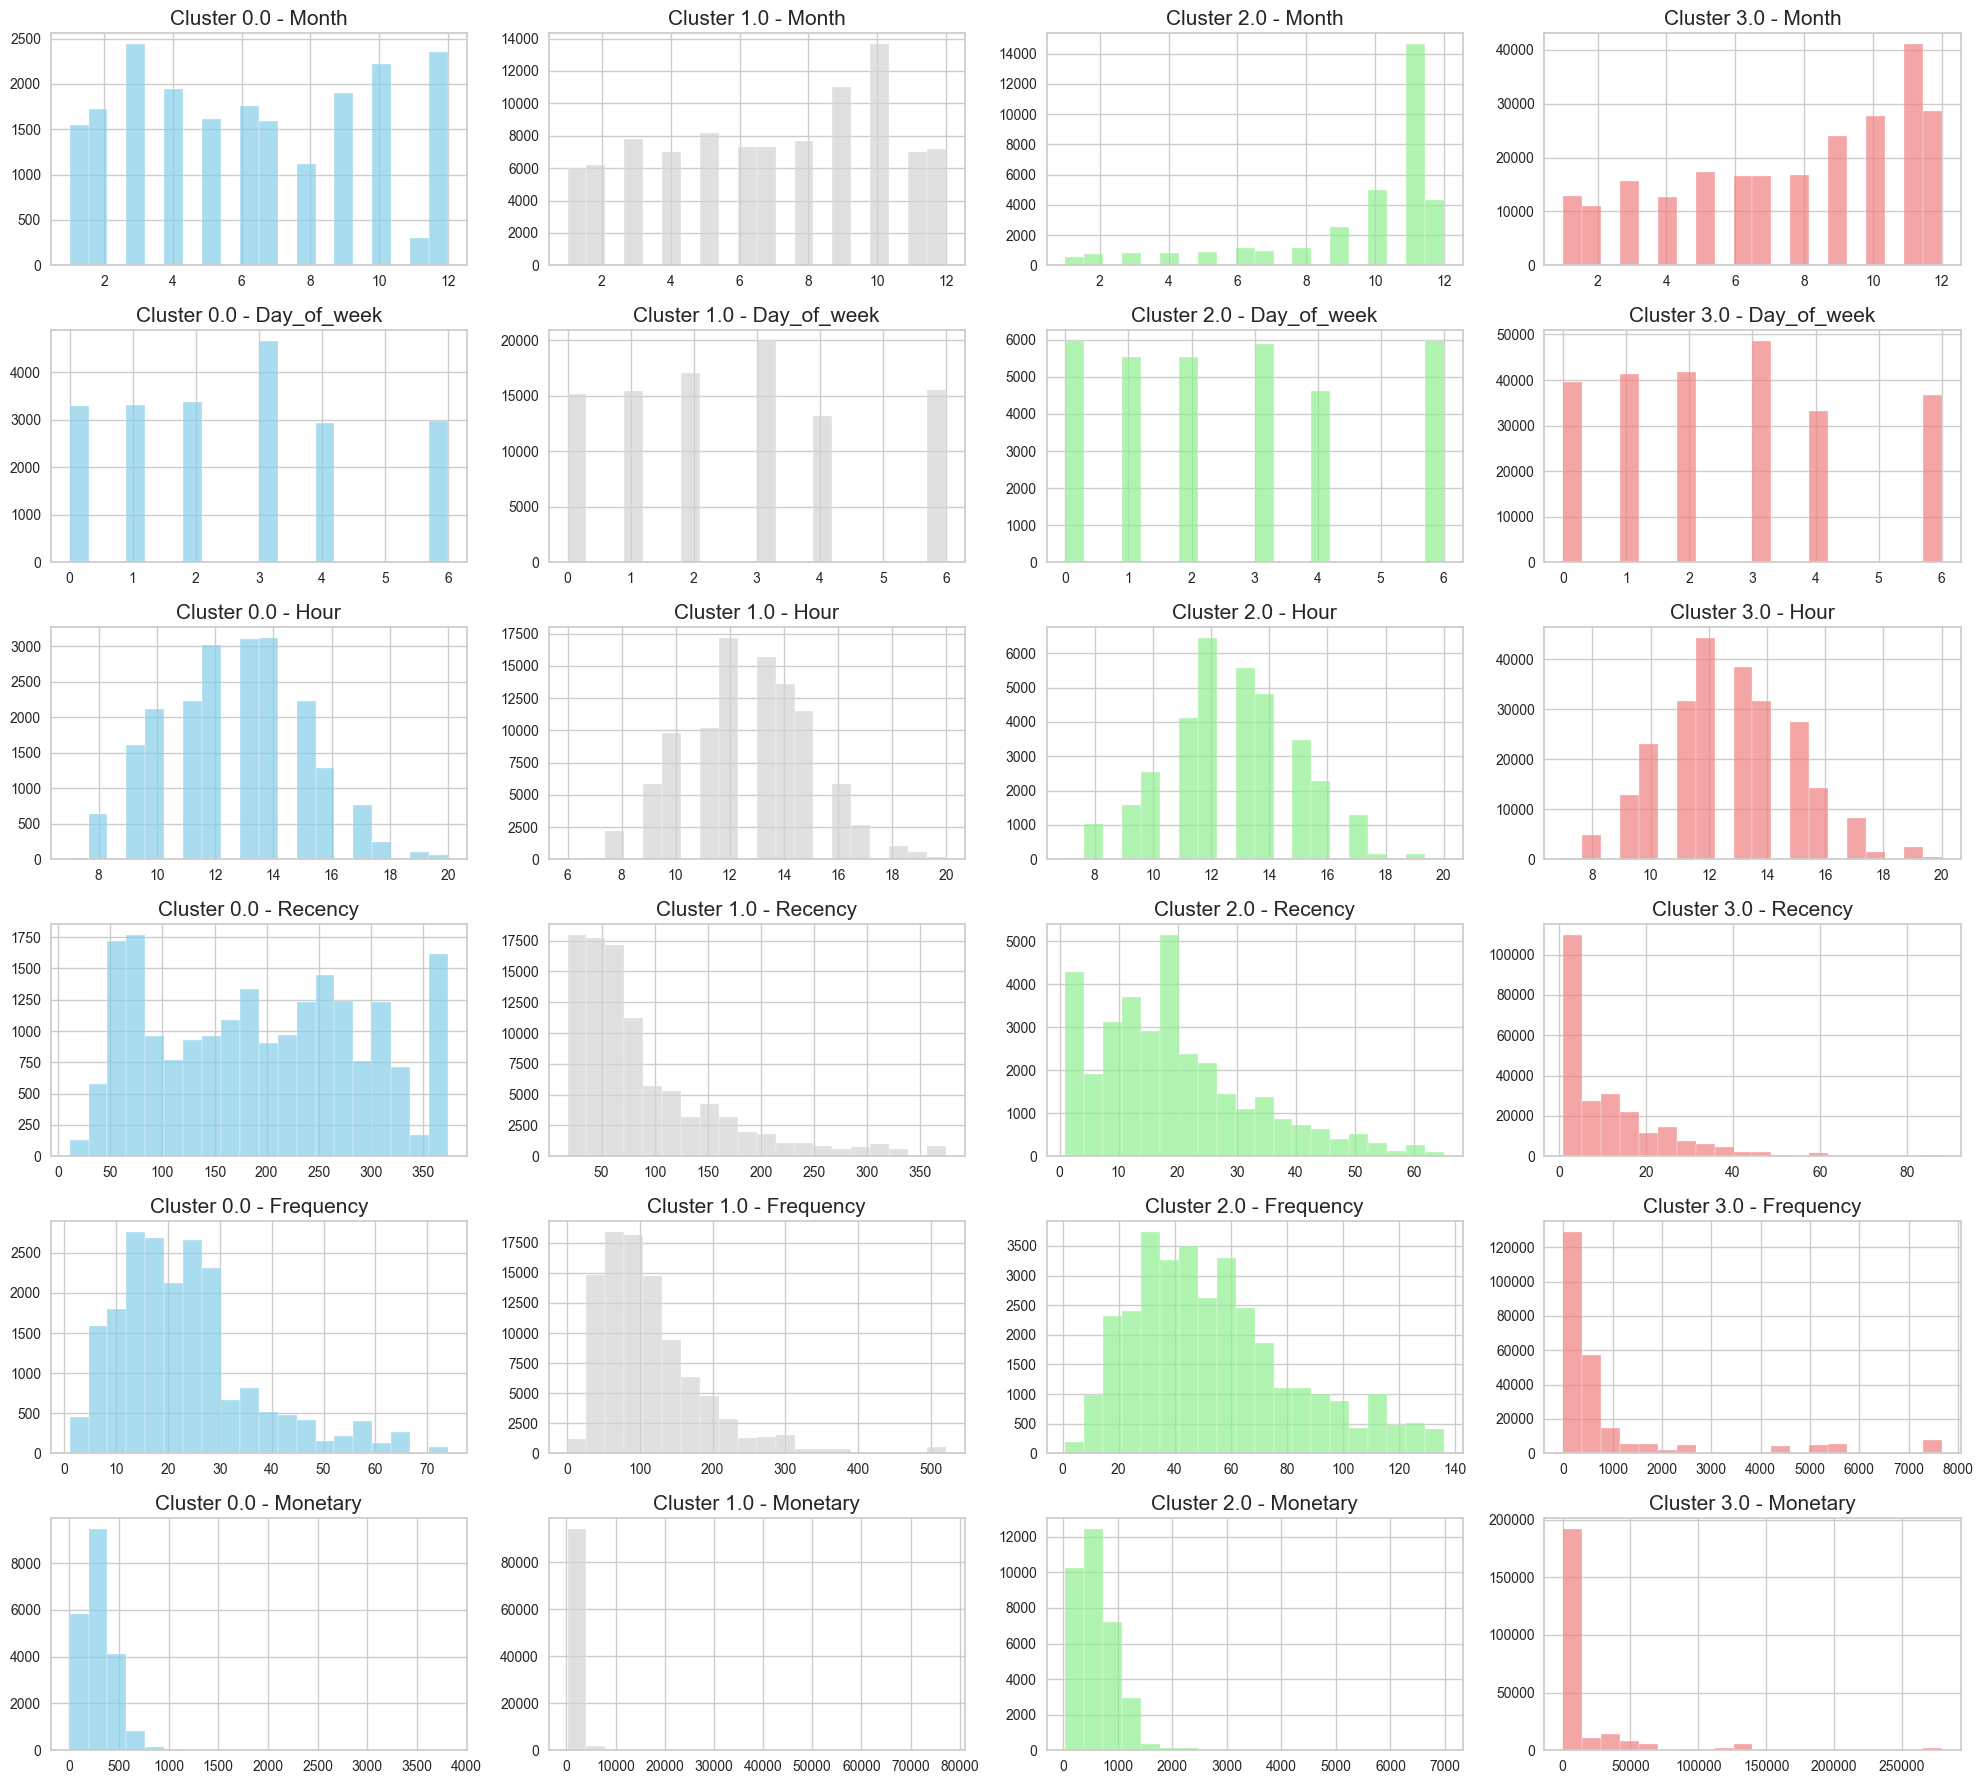

In [97]:
# 클러스터별 특징 hist 
# Plot histograms for each feature segmented by the clusters
features = [ 'Month', 'Day_of_week', 'Hour',  'Recency', 'Frequency', 'Monetary']
clusters = final_df['Cluster'].unique()
clusters.sort()


n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))

cluster_colors = ['skyblue', 'lightgray', 'lightgreen', 'lightcoral']  

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = final_df[final_df['Cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=cluster_colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

- Cluster 0:
    - 1.월별 지출 변동이 낮은편으로, 꾸준한 구매 패턴이 있지만 , 주문 빈도와 구매액은 가장 낮다.
    - 2.홈 인테리어 소품 관련 상품을 선호한다.
    - 3.낮12~ 14시에 집중적으로 구매하는 패턴이 있다.
    - 4.At-Risk(이탈 위험 고객) 43.4% , Cannot lose them(놓칠수 없는 고객) 23.3% 비중 "
- Cluster 1
    - 1.주문당 수량 및 주문당 구매액이 비교적 높은 그룹으로, 대량 구매를 선호하는 구매 패턴
    - 2.이벤트나 파티에 사용되는 상품을 선호한다.
    - 3.Promising (유망한 고객) 38.6% ,About to sleep(잠들기 직전 고객 ) 31.4% 비중
- Cluster 2
    - 1.월별 지출 변동이 큰 편으로, 10~12월 겨울 시즌에 구매가 활발한 패턴을 보인다.
    - 2.주문당 수량 및 주문당 구매액이 비교적 낮은 것으로, 소량 구매를 선호하는 구매 패턴
    - 3.크리스마스 관련 상품 및 런치백 등의 잡화류 상품을 선호한다.
    - 4.Loyal customer(충성 고객) 37.3%,New customer(신규 고객) 35.2% 비중
- Cluster 3
    - 1.주문 건수와 총 구매액이 가장 높은 그룹
    - 2.다른 클러스터 대비 비교적 다양한 상품에서 선호도가 나타남
    - 3.VIP 66.7%,Potential Loyalists(유망한 충성 고객) 24.9% 

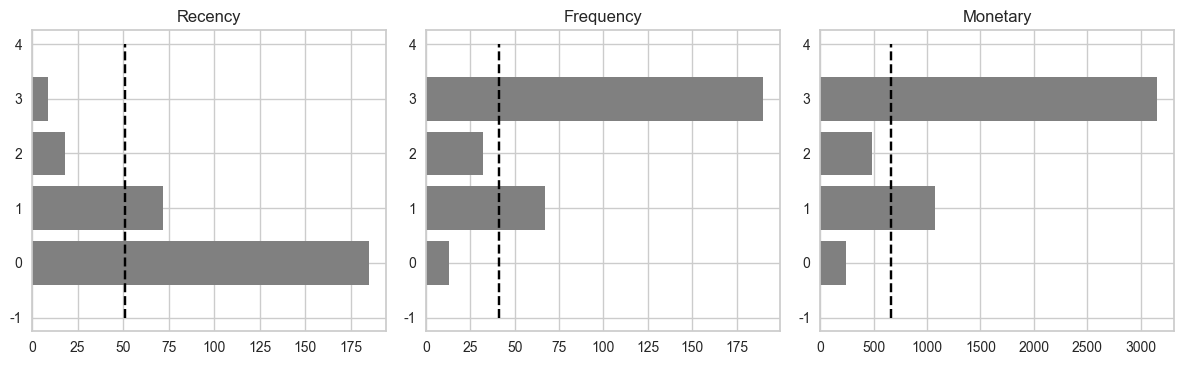

In [98]:
# 클러스터별 rfm 분석 
def dist_list(lst):
    plt.figure(figsize=[12, 7])
    i = 1
    for col in lst:
        ax = plt.subplot(2, 3, i)
        ax.vlines(rfm1[col].median(), ymin=-1, ymax=4, color='black', linestyle='--')
        g = rfm1.groupby('Cluster')
        x = g[col].median().index
        y = g[col].median().values
        ax.barh(x, y, color='grey') 
        plt.title(col)
        i = i + 1

dist_list(['Recency','Frequency', 'Monetary'])
plt.tight_layout()
plt.show()

In [99]:
# 클러스터별 segment cnt 

cluster_segment_sep=final_df.groupby(['Cluster','RFM_segment'])['RFM_segment'].size().reset_index(name='cnt')
cluster_segment_sep.head()

,Cluster,RFM_segment,cnt
0,0.0,About To Sleep,497
1,0.0,At-Risk,8904
2,0.0,Cannot lose them,5486
3,0.0,Hibernating,2445
4,0.0,Need Attention,2963


In [100]:
# 클러스터별 segment 분포 
cluster_total_counts = cluster_segment_sep.groupby('Cluster')['cnt'].sum().reset_index(name='total_counts')
cluster_total_counts

cluster_segment_sep=cluster_segment_sep.merge(cluster_total_counts,on='Cluster',how='left')
cluster_segment_sep['ratio']=cluster_segment_sep['cnt']/cluster_segment_sep['total_counts']
cluster_segment_sep

,Cluster,RFM_segment,cnt,total_counts,ratio
0,0.0,About To Sleep,497,20505,0.024238
1,0.0,At-Risk,8904,20505,0.434236
2,0.0,Cannot lose them,5486,20505,0.267545
3,0.0,Hibernating,2445,20505,0.119239
4,0.0,Need Attention,2963,20505,0.144501
5,0.0,New customers,206,20505,0.010046
6,0.0,Potential Loyalists,4,20505,0.000195
7,1.0,About To Sleep,30187,96201,0.313791
8,1.0,At-Risk,10577,96201,0.109947
9,1.0,Cannot lose them,1318,96201,0.013700


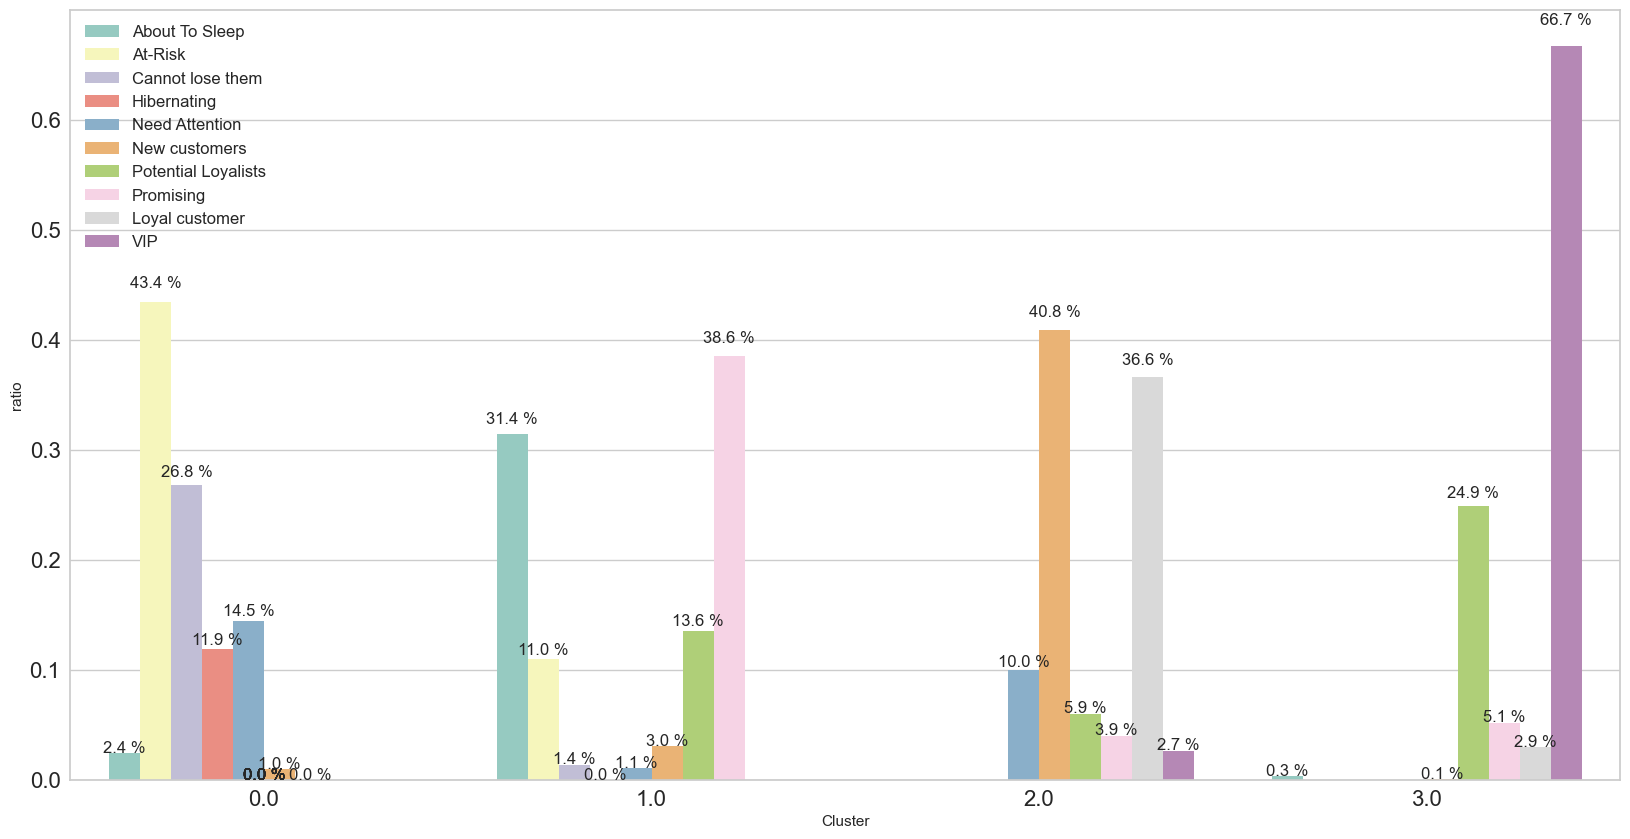

In [101]:
# 클러스터별 RFM segment 분포 확인 

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=cluster_segment_sep['Cluster'], y=cluster_segment_sep['ratio'], hue=cluster_segment_sep['RFM_segment'], ax=ax, palette='Set3',
           
            
    )

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f %%" % (height * 100), (left + width / 2, height * 1.03), ha='center')

# x 축 레이블 폰트 크기 설정
ax.tick_params(axis='x', labelsize=16)

# y 축 레이블 폰트 크기 설정
ax.tick_params(axis='y', labelsize=16)

ax.legend(fontsize=12)  # fontsize 조절


plt.show()



In [102]:
# 클러스터별 판매 top 10 상품 
cluster_item_cnt=final_df.groupby(['Cluster','Description'])['Description'].size().reset_index(name='cnt').sort_values(by=['Cluster','cnt'],ascending=[True,False])
top_items_by_cluster = cluster_item_cnt.groupby('Cluster').head(10)


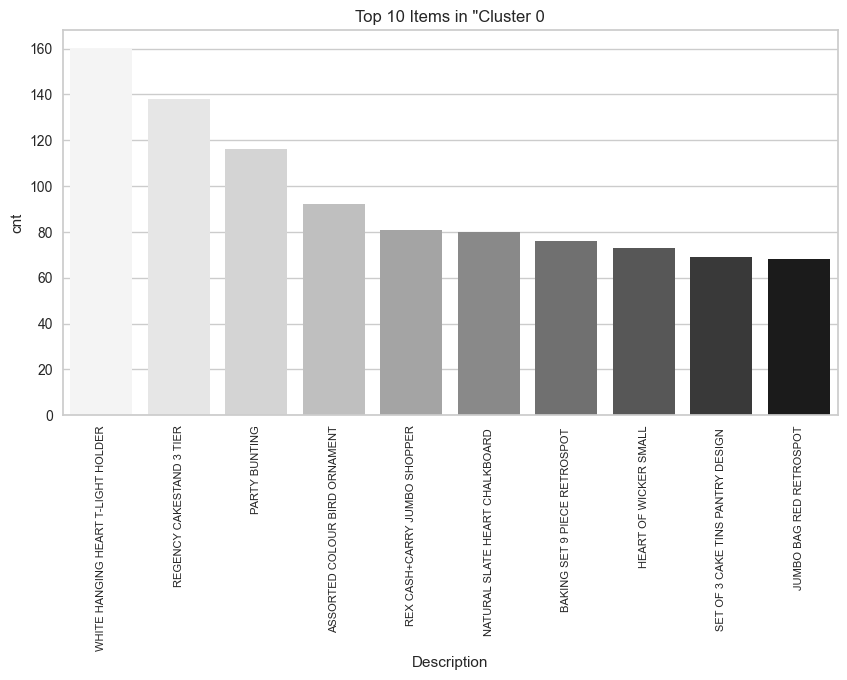

,Cluster,Description,cnt
2752,0.0,WHITE HANGING HEART T-LIGHT HOLDER,160
2053,0.0,REGENCY CAKESTAND 3 TIER,138
1752,0.0,PARTY BUNTING,116
164,0.0,ASSORTED COLOUR BIRD ORNAMENT,92
2088,0.0,REX CASH+CARRY JUMBO SHOPPER,81
1605,0.0,NATURAL SLATE HEART CHALKBOARD,80
207,0.0,BAKING SET 9 PIECE RETROSPOT,76
1210,0.0,HEART OF WICKER SMALL,73
2234,0.0,SET OF 3 CAKE TINS PANTRY DESIGN,69
1332,0.0,JUMBO BAG RED RETROSPOT,68


In [103]:
cluster_0 = top_items_by_cluster[top_items_by_cluster['Cluster'] == 0]

plt.figure(figsize=(10, 5))
sns.barplot(x='Description', y='cnt', data=cluster_0,palette='Greys',hue='Description',legend=False)
plt.xticks(rotation=90,size=8)
plt.title('Top 10 Items in "Cluster 0')
plt.show()
cluster_0

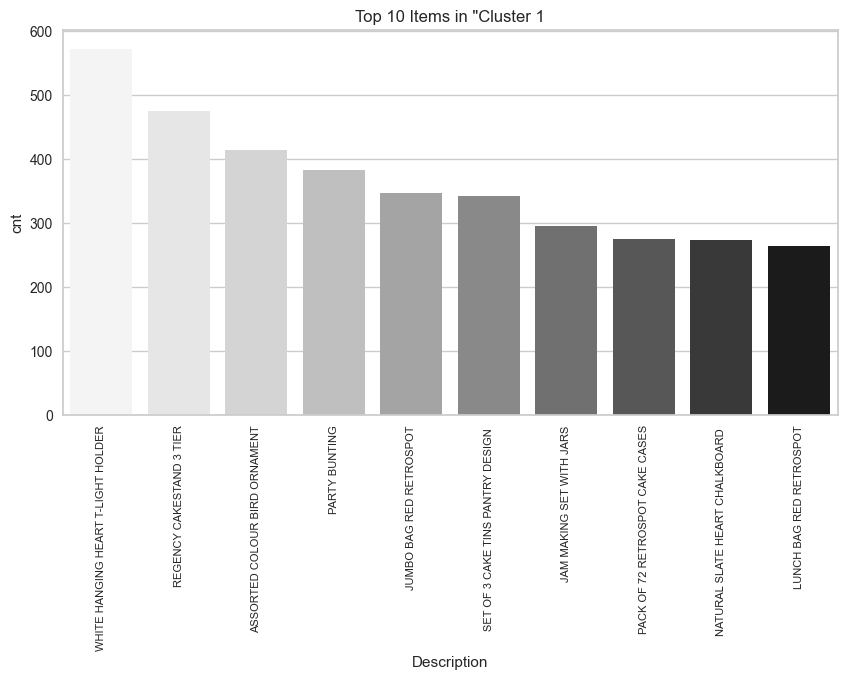

,Cluster,Description,cnt
6199,1.0,WHITE HANGING HEART T-LIGHT HOLDER,573
5347,1.0,REGENCY CAKESTAND 3 TIER,476
3083,1.0,ASSORTED COLOUR BIRD ORNAMENT,415
4988,1.0,PARTY BUNTING,383
4467,1.0,JUMBO BAG RED RETROSPOT,348
5566,1.0,SET OF 3 CAKE TINS PANTRY DESIGN,342
4435,1.0,JAM MAKING SET WITH JARS,296
4919,1.0,PACK OF 72 RETROSPOT CAKE CASES,276
4799,1.0,NATURAL SLATE HEART CHALKBOARD,274
4620,1.0,LUNCH BAG RED RETROSPOT,265


In [104]:
cluster_1 = top_items_by_cluster[top_items_by_cluster['Cluster'] == 1]

plt.figure(figsize=(10, 5))
sns.barplot(x='Description', y='cnt', data=cluster_1,palette='Greys',hue='Description',legend=False)
plt.xticks(rotation=90,size=8)
plt.title('Top 10 Items in "Cluster 1')
plt.show()
cluster_1

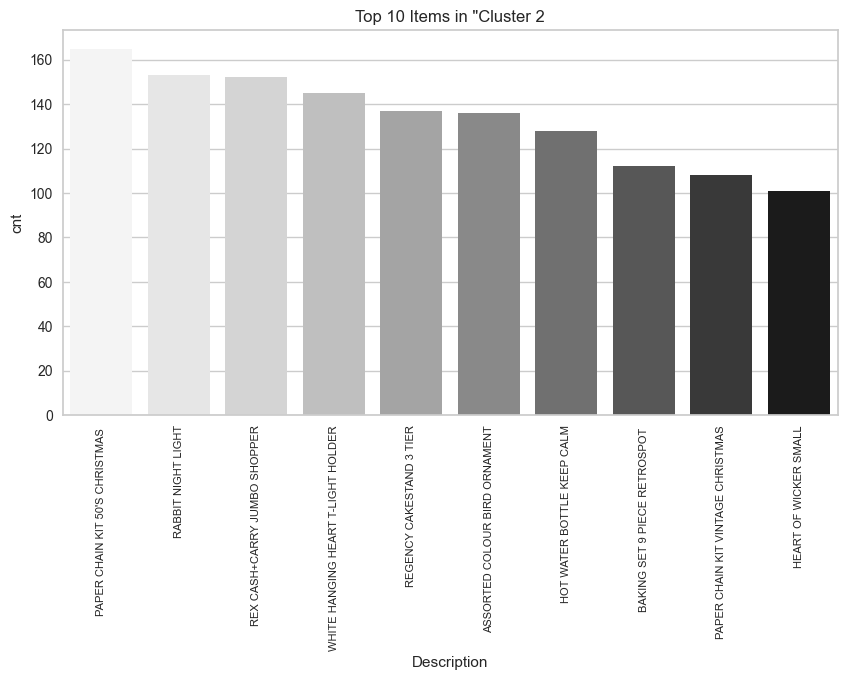

,Cluster,Description,cnt
8086,2.0,PAPER CHAIN KIT 50'S CHRISTMAS,165
8327,2.0,RABBIT NIGHT LIGHT,153
8466,2.0,REX CASH+CARRY JUMBO SHOPPER,152
9171,2.0,WHITE HANGING HEART T-LIGHT HOLDER,145
8429,2.0,REGENCY CAKESTAND 3 TIER,137
6523,2.0,ASSORTED COLOUR BIRD ORNAMENT,136
7580,2.0,HOT WATER BOTTLE KEEP CALM,128
6567,2.0,BAKING SET 9 PIECE RETROSPOT,112
8091,2.0,PAPER CHAIN KIT VINTAGE CHRISTMAS,108
7532,2.0,HEART OF WICKER SMALL,101


In [105]:
cluster_2 = top_items_by_cluster[top_items_by_cluster['Cluster'] == 2]

plt.figure(figsize=(10, 5))
sns.barplot(x='Description', y='cnt', data=cluster_2,palette='Greys',hue='Description',legend=False)
plt.xticks(rotation=90,size=8)
plt.title('Top 10 Items in "Cluster 2')
plt.show()
cluster_2

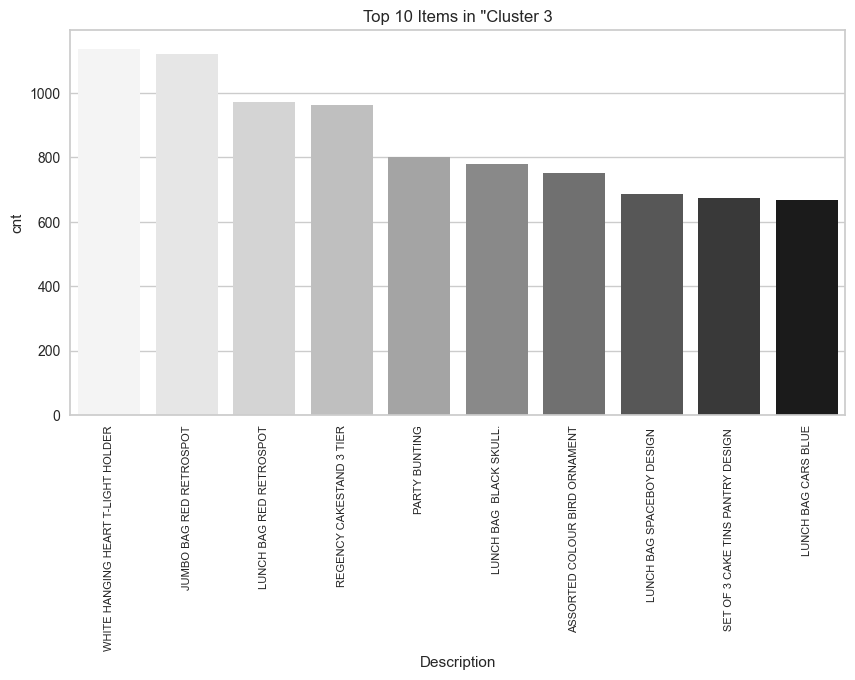

,Cluster,Description,cnt
12829,3.0,WHITE HANGING HEART T-LIGHT HOLDER,1138
10971,3.0,JUMBO BAG RED RETROSPOT,1122
11142,3.0,LUNCH BAG RED RETROSPOT,972
11925,3.0,REGENCY CAKESTAND 3 TIER,962
11525,3.0,PARTY BUNTING,801
11134,3.0,LUNCH BAG BLACK SKULL.,781
9511,3.0,ASSORTED COLOUR BIRD ORNAMENT,752
11145,3.0,LUNCH BAG SPACEBOY DESIGN,686
12151,3.0,SET OF 3 CAKE TINS PANTRY DESIGN,673
11137,3.0,LUNCH BAG CARS BLUE,668


In [106]:
cluster_3 = top_items_by_cluster[top_items_by_cluster['Cluster'] == 3]

plt.figure(figsize=(10, 5))
sns.barplot(x='Description', y='cnt', data=cluster_3,palette='Greys',hue='Description',legend=False)
plt.xticks(rotation=90,size=8)
plt.title('Top 10 Items in "Cluster 3')
plt.show()
cluster_3

# 7.장바구니 분석 

- 클러스터별 장바구니 분석 

In [107]:
final_df['Cluster'].value_counts()

Cluster
3.0    240841
1.0     96201
2.0     33521
0.0     20505
Name: count, dtype: int64

- 클러스터 별 볼륨이 상이하나, 중요도는 3>2>1>0순으로, 각 중요도에 따라 샘플링 

In [108]:
# cluster 0
cluster_0=final_df[final_df['Cluster']==0]
cluster_0_basket = cluster_0.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0).applymap(lambda x: True if x > 0 else False)
cluster_0_frequent_itemsets = apriori(cluster_0_basket, min_support=0.02, use_colnames=True)
cluster_0_frequent_itemsets
cluster_0_rules= association_rules(cluster_0_frequent_itemsets, metric="lift", min_threshold=0.8)
cluster_0_rules.sort_values(by='confidence',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
16,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.022496,0.043541,0.021045,0.935484,21.484946,0.020065,14.825109,0.975399
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031930,0.043541,0.027576,0.863636,19.834848,0.026186,7.014030,0.980904
0,(PAINTED METAL PEARS ASSORTED),(ASSORTED COLOUR BIRD ORNAMENT),0.029028,0.061684,0.023222,0.800000,12.969412,0.021432,4.691582,0.950486
17,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.027576,0.041364,0.021045,0.763158,18.449677,0.019904,4.047573,0.972620
6,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.041364,0.043541,0.029753,0.719298,16.519883,0.027952,3.407384,0.980004


- 클러스터 0의 연관 규칙:ROSES REGENCY TEACUP AND SAUCER와 PINK REGENCY TEACUP AND SAUCER
  
=> ROSES REGENCY TEACUP AND SAUCER와 PINK REGENCY TEACUP AND SAUCER를 구매한 고객 중 약 93.5%는 GREEN REGENCY TEACUP AND SAUCER 도 구매한다. 

=> 두 제품 간의 연관성이 높으므로, 이를 함께 마케팅하거나 특별한 할인 혜택을 제공할 수 있습니다.

In [109]:
# cluster 1
cluster_1=final_df[final_df['Cluster']==1]
cluster_1_basket = cluster_1.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0).applymap(lambda x: True if x > 0 else False)
cluster_1_frequent_itemsets = apriori(cluster_1_basket, min_support=0.02, use_colnames=True)
cluster_1_frequent_itemsets
cluster_1_rules= association_rules(cluster_1_frequent_itemsets, metric="lift", min_threshold=0.8)
cluster_1_rules.sort_values(by='lift',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
11091,(PACK OF 6 SKULL PAPER PLATES),"(PACK OF 6 SKULL PAPER CUPS, PACK OF 20 SKULL ...",0.022333,0.020678,0.020678,0.925926,44.777778,0.020216,13.220844,1.000000
11090,"(PACK OF 6 SKULL PAPER CUPS, PACK OF 20 SKULL ...",(PACK OF 6 SKULL PAPER PLATES),0.020678,0.022333,0.020678,1.000000,44.777778,0.020216,inf,0.998311
20151,"(PINK POLKADOT CUP, RED RETROSPOT BOWL)","(RED RETROSPOT CUP, BLUE POLKADOT CUP, PINK PO...",0.023987,0.021505,0.020678,0.862069,40.086207,0.020162,7.094086,0.999017
20146,"(RED RETROSPOT CUP, BLUE POLKADOT CUP, PINK PO...","(PINK POLKADOT CUP, RED RETROSPOT BOWL)",0.021505,0.023987,0.020678,0.961538,40.086207,0.020162,25.376344,0.996484
4139,(PACK OF 6 SKULL PAPER CUPS),(PACK OF 6 SKULL PAPER PLATES),0.024814,0.022333,0.021505,0.866667,38.807407,0.020951,7.332506,0.999021


- 클러스터 1의 연관 규칙:SET/10 BLUE POLKADOT PARTY CANDLES 과 SET/10 PINK POLKADOT PARTY CANDLES

=> 두 제품을 함께 구매하는 고객이 많으며,SET/10 BLUE POLKADOT PARTY CANDLES  구매시, 90.4%로 확률로 SET/10 PINK POLKADOT PARTY CANDLES를 구매한다. 

=> 이를 함께 판매하는등의 상품 번들구성을 기획할 수 있다. 


In [111]:
# cluster 2
cluster_2=final_df[final_df['Cluster']==2]
sample_size = 30000  
cluster_2_sample = cluster_2.sample(sample_size, random_state=42)
cluster_2_basket = cluster_2_sample.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0).applymap(lambda x: True if x > 0 else False)
cluster_2_frequent_itemsets = apriori(cluster_2_basket, min_support=0.02, use_colnames=True)
cluster_2_rules= association_rules(cluster_2_frequent_itemsets, metric="lift", min_threshold=0.8)
cluster_2_rules.sort_values(by='confidence',ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
158,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023756,0.041855,0.020362,0.857143,20.478764,0.019368,6.707014,0.974314
7,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT ),0.045249,0.102941,0.038462,0.850000,8.257143,0.033804,5.980392,0.920546
166,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN HE...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.032805,0.076923,0.026018,0.793103,10.310345,0.023495,4.461538,0.933638
159,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.026018,0.048643,0.020362,0.782609,16.088979,0.019096,4.376244,0.962898
40,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.033937,0.041855,0.026018,0.766667,18.317117,0.024598,4.106335,0.978617


- 클러스터 2 연관 규칙 : BAKING SET SPACEBOY DESIGN 와JBAKING SET 9 PIECE RETROSPOT
BAKING SET SPACEBOY DESIGN을  구매하는 고객은 85.7% 확률로 BAKING SET 9 PIECE RETROSPOT 상품을 구매하므로,

=> 추가 할인 혜택 제공 시,cvr 상승 예측 


In [112]:
# cluster 3
cluster_3=final_df[final_df['Cluster']==3]
sample_size = 50000  
cluster_3_sample = cluster_3.sample(sample_size, random_state=42)
cluster_3_basket = cluster_3_sample.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0).applymap(lambda x: True if x > 0 else False)
cluster_3_frequent_itemsets = apriori(cluster_3_basket, min_support=0.02, use_colnames=True)
cluster_3_rules= association_rules(cluster_3_frequent_itemsets, metric="lift", min_threshold=0.8)
cluster_3_rules.sort_values(by='confidence',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2038,"(LUNCH BAG CARS BLUE, CHARLOTTE BAG SUKI DESIGN)",(RED RETROSPOT CHARLOTTE BAG),0.023175,0.082271,0.023175,1.000000,12.154930,0.021268,inf,0.939502
2321,"(JUMBO BAG SPACEBOY DESIGN, JUMBO BAG PINK VIN...",(JUMBO BAG PINK POLKADOT),0.024334,0.091541,0.023175,0.952381,10.403858,0.020947,19.077636,0.926425
3556,"(LUNCH BAG RED RETROSPOT, LUNCH BAG APPLE DESI...",(LUNCH BAG BLACK SKULL.),0.022016,0.133256,0.020857,0.947368,7.109382,0.017924,16.468134,0.878686
2574,"(JUMBO BAG SCANDINAVIAN BLUE PAISLEY, LUNCH BA...",(JUMBO BAG RED RETROSPOT),0.026651,0.165701,0.024334,0.913043,5.510185,0.019918,9.594438,0.840930
2568,"(JUMBO BAG SCANDINAVIAN BLUE PAISLEY, JUMBO ST...",(JUMBO BAG RED RETROSPOT),0.025492,0.165701,0.023175,0.909091,5.486332,0.018951,9.177289,0.839120


- 클러스터 3 연관 규칙 :RED HANGING HEART T-LIGHT HOLDER 와 WHITE HANGING HEART T-LIGHT HOLDER
- RED HANGING HEART T-LIGHT HOLDER 을 구매하는 고객은 71.4% 의 확률로 WHITE HANGING HEART T-LIGHT HOLDER을 구매한다. 

# 8.추천시스템 


In [115]:
# 사용자 -상품 행렬 생성 
user_item_matrix = pd.pivot_table(final_df, index='CustomerID', columns='Description', values='Quantity', fill_value=0)
user_item_matrix.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
final_df[['Cluster','CustomerID']]

,Cluster,CustomerID
0,1.0,17850.0
1,1.0,17850.0
2,1.0,17850.0
3,1.0,17850.0
4,1.0,17850.0
...,...,...
391063,2.0,12680.0
391064,2.0,12680.0
391065,2.0,12680.0
391066,2.0,12680.0


In [120]:
# 클러스터별로 사용자-상품 행렬을 나누고 유사도 행렬 계산

cluster_user_item_matrices = [pd.pivot_table(cluster_df, index='CustomerID', columns='Description', values='Quantity', fill_value=0) for _, cluster_df in final_df.groupby('Cluster')]
cluster_item_similarity = [cosine_similarity(cluster_user_item_matrix.T) for cluster_user_item_matrix in cluster_user_item_matrices]


In [121]:
# 클러스터별로 상품 추천
def recommend_items_in_cluster(cluster_id, user_id, num_recommendations=1):
    cluster_user_item_matrix = cluster_user_item_matrices[cluster_id]
    user_item_vector = cluster_user_item_matrix.loc[user_id]
    non_purchased_items = user_item_vector[user_item_vector == 0].index  # 구매하지  않은 상품 필터링
    scores = np.dot(cluster_item_similarity[cluster_id], cluster_user_item_matrix.T[user_id])
    
    # 추천할 상품 인덱스 추출
    recommended_items = non_purchased_items[np.argsort(scores)[::-1][:num_recommendations]].to_list()
    
    return  pd.DataFrame({'recommend_items':recommended_items})


In [133]:
# 예시: 클러스터 2에서 사용자 12680.0 10개의 상품을 추천
cluster_id = 2
user_id = 12680.0
num_recommendations = 10
recommended_items_cluster_0 = recommend_items_in_cluster(cluster_id, user_id, num_recommendations)
recommended_items_cluster_0

,recommend_items
0,GIFT BAG BIRTHDAY
1,CARD GINGHAM ROSE
2,PACK OF 6 SANDCASTLE FLAGS ASSORTED
3,PAPERWEIGHT VINTAGE COLLAGE
4,PAINT YOUR OWN EGGS IN CRATE
5,PACK OF SIX LED TEA LIGHTS
6,PAPERWEIGHT VINTAGE PAISLEY
7,DOORMAT NEW ENGLAND
8,POPPY FIELDS CHOPPING BOARD
9,POPPY'S PLAYHOUSE KITCHEN
